<hr style="height:0px; visibility:hidden;" />

<h1><center><b>GL4U: RNAseq<b></center></h1>

# Pipeline for Analyzing GeneLab RNA-sequencing Data

> **The 2 GL4U RNAseq Jupyter Notebooks (JNs) are designed to teach students how to process and analyze RNA sequencing data using the GeneLab standard pipeline. Below are step-by-step instructions for analyzing count data from samples derived from the soleus (aka "anti-gravity") muscle of mice that were either flown in space aboard the International Space Station (ISS) (spaceflight, FLT, animals) or kept in an environmental simulator on Earth to serve as ground controls (GC, animals) during NASA's Rodent Research - 1 mission. We will start our analysis with the OSD-104 RSEM gene count data that we generated using the [RNAseq processing JN](01-RNAseq_processing.ipynb). More information about the samples analyzed here can be found in the [Open Science Data Repository](https://osdr.nasa.gov/bio/repo) under [OSD-104](https://osdr.nasa.gov/bio/repo/data/studies/OSD-104).**  

---

### RNAseq Pipeline Overview
> This JN will cover the pipeline steps outlined in red. For more information about how GeneLab processes bulk RNAseq data, visit the [GeneLab Data Processing GitHub repository](https://github.com/nasa/GeneLab_Data_Processing/tree/master/RNAseq).  

<br>

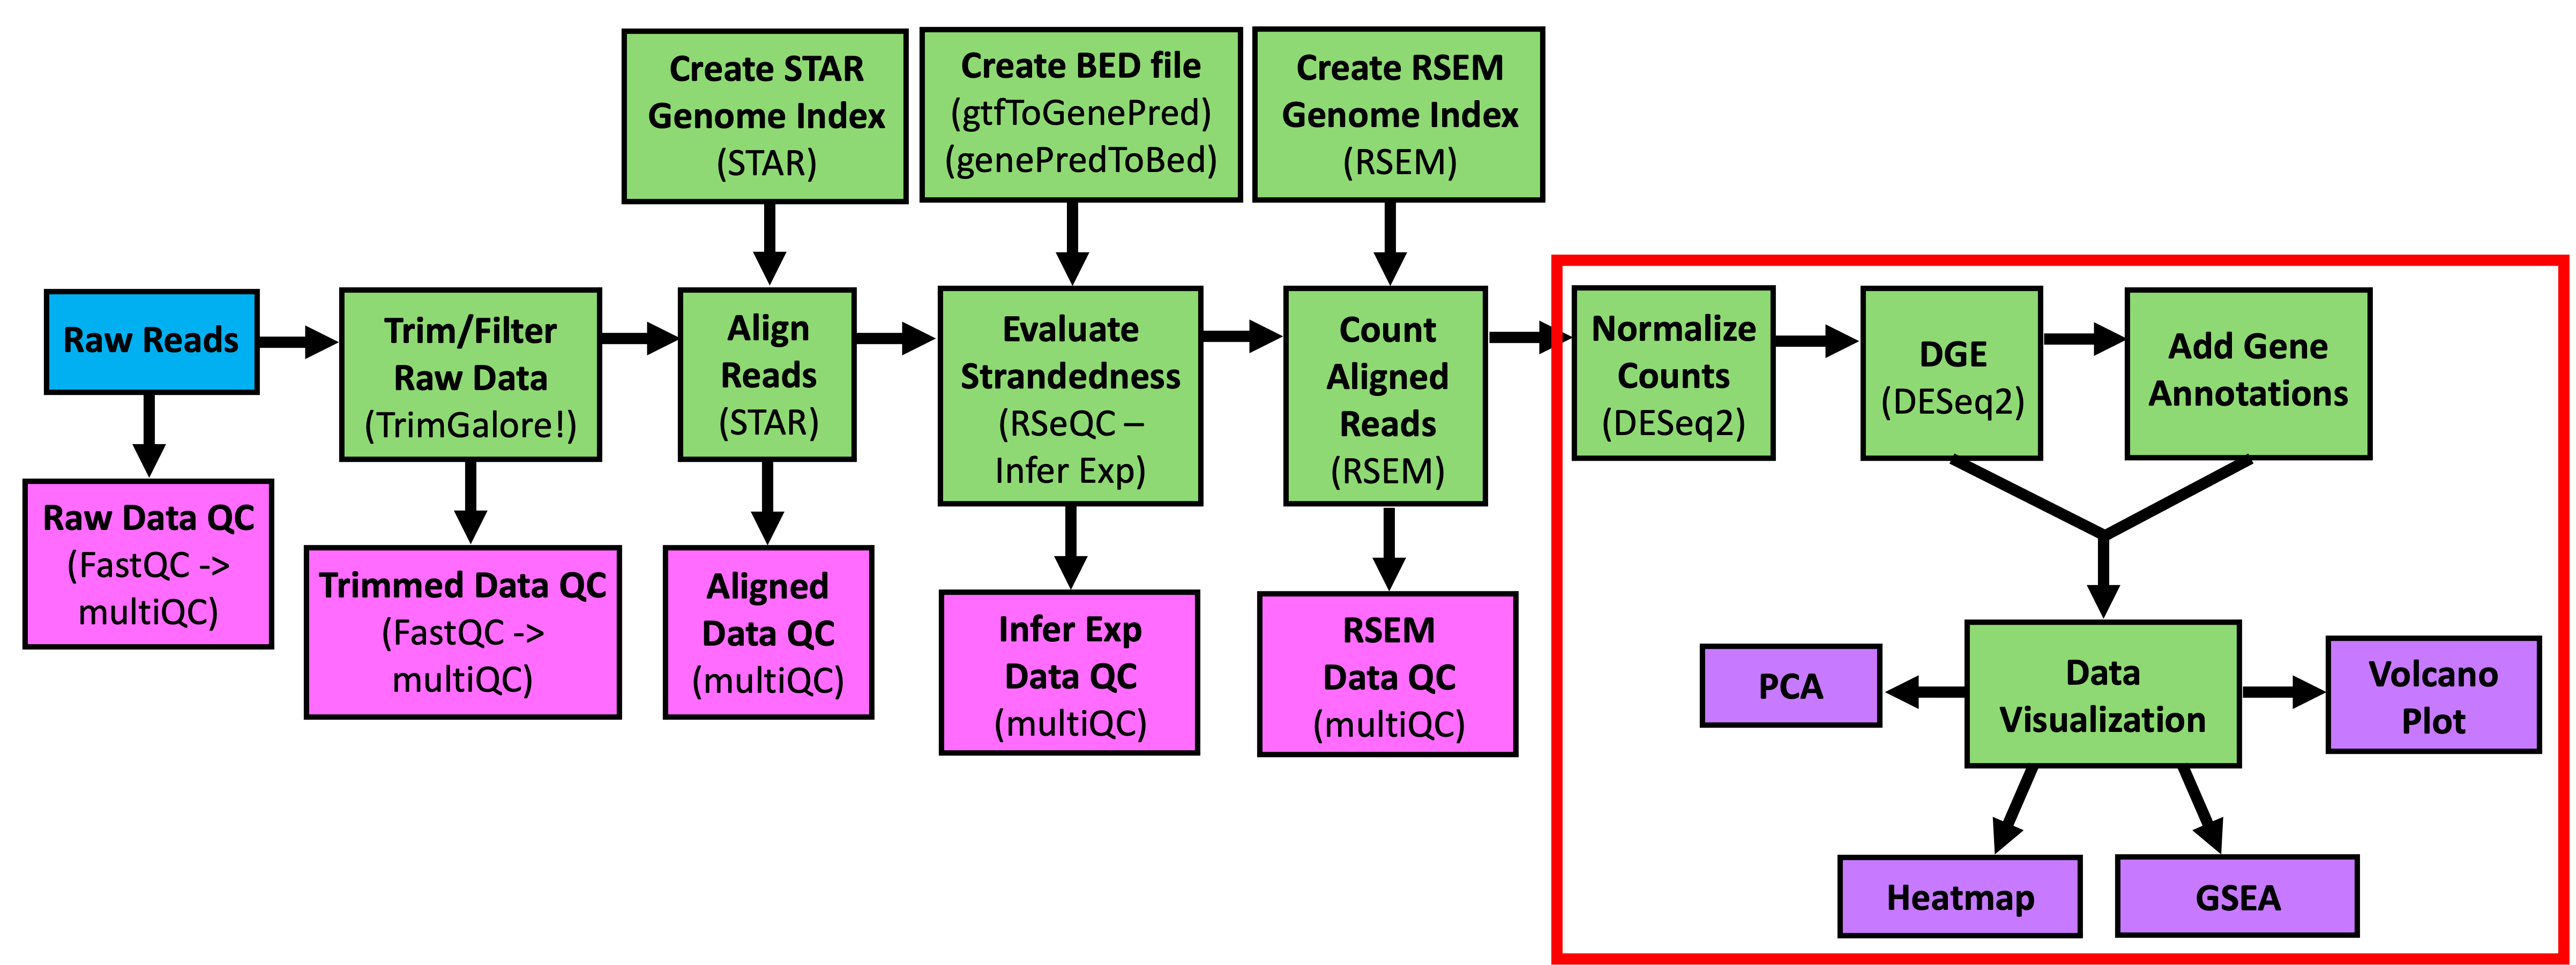

<hr style="height:0px; visibility:hidden;" />
    
<h1><center>2. RNAseq analysis: DGE, annotations, and data visualization</center></h1>

<div class="alert alert-block alert-success">
Here we are going to setup a directory structure to store the output data we'll generate, then we will follow the steps in the GeneLab standard RNAseq processing pipeline to perform differential gene expression (DGE), add annotations, and generate data visualizations. All of these steps are done using tools in R, so this notebook uses a "R" kernel. 
</div>

---

This is notebook 2 of 2 of GL4U's RNAseq Module Set. It is expected that GL4U's Introduction Module Set and the previous RNAseq module has been completed already. 

---
[**Previous:** 1. RNAseq processing](01-RNAseq_processing.ipynb)
<br> 

<div style="text-align: right"><a href="03-RNAseq_analysis_anyOSD.ipynb"><b>Optional Next:</b> 3. RNAseq analysis any OSD</a></div> 
<br> 

---
---

# Table of Contents 


* [0. Load R Libraries](#0.-Load-R-Libraries) 
* [1. Import and Format Data](#1.-Import-and-Format-Data) 
    * [1a. Set up Directory Paths](#1a.-Setup-Directory-Paths) 
    * [1b. Import the Data](#1b.-Import-the-Data)
    * [1c. Make DESeqDataSet Object](#1c.-Make-DESeqDataSet-Object)
* [2. DESeq2 Analysis](#2.-DESeq2-Analysis)
    * [2a. PCA of Raw, Unnormalized Count Data](#2a.-PCA-of-Raw,-Unnormalized-Count-Data)
    * [2b. DESeq2 Step 1: Size Factor Estimation](#2b.-DESeq2-Step-1:-Size-Factor-Estimation)
    * [2c. DESeq2 Step 2: Estimate Gene Dispersions](#2c.-DESeq2-Step-2:-Estimate-Gene-Dispersions)
    * [2d. DESeq2 Step 3: Hypothesis Testing with Wald Test](#2d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test)
* [3. DGE Analysis](#3.-DGE-Analysis)
    * [3a. Perform Data Calculations and Create DGE Output Table](#3a.-Perform-Data-Calculations-and-Create-DGE-Output-Table)
    * [3b. Add Gene Annotations](#3b.-Add-Gene-Annotations)
* [4. DGE Data Visualization](#4.-DGE-Data-Visualization)
    * [4a. PCA](#4a.-PCA)
    * [4b. Heatmap](#4b.-Heatmap)
    * [4c. Volcano Plot](#4c.-Volcano-Plot)
    * [4d. Gene Set Enrichment Analysis (GSEA)](#4d.-Gene-Set-Enrichment-Analysis-(GSEA))
* [5. So now what?](#5.-So-now-what?)


<a id="loadlibraries"></a>
# 0. Load R Libraries

We will be performing our DGE analysis in the R programming language using several R packages, which have all been installed for you. Prior to beginning the analysis, we first have to load the R packages we will be using by importing the library directories where they are stored. 

<a class="anchor" id="libraries"></a>
## Import R Libraries

Import R library that will allow us to read in the RSEM raw counts data table: 

In [56]:
library(tximport)

Import R libraries that will allow us to run DGE analysis with DESeq2:

In [57]:
library(DESeq2)
library(tidyverse)

Import R libraries that will allow us to add gene annotations to the DGE output table:

In [58]:
library(org.Mm.eg.db)
library(STRINGdb)
library(PANTHER.db)

Import R libraries that will allow us to perform data visualization:

In [59]:
library(ggfortify)
library(ComplexHeatmap)
library(EnhancedVolcano)
library(tidyHeatmap)
library(clusterProfiler)
library(goseq)
library(fgsea)
library(enrichplot)
library(ggnewscale)

<br>

---

<a class="anchor" id="data"></a>
# 1. Import and Format Data

<a class="anchor" id="dirs"></a>
## 1a. Setup Directory Paths

**Create Output Directories**

Let's start by creating sub-directories within our `OSD-104` top-level directory to store the output files we will generate. 

In [60]:
dir.create("/workspace/GeneLab-Training/OSD-104/04-DESeq2_NormCounts/PCA", recursive = TRUE)
dir.create("/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/PCA", recursive = TRUE)
dir.create("/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/Heatmaps", recursive = TRUE)
dir.create("/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/VolcanoPlots", recursive = TRUE)
dir.create("/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/GSEA", recursive = TRUE)

Warning message in dir.create("/workspace/GeneLab-Training/OSD-104/04-DESeq2_NormCounts/PCA", :
“'/workspace/GeneLab-Training/OSD-104/04-DESeq2_NormCounts/PCA' already exists”
Warning message in dir.create("/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/PCA", :
“'/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/PCA' already exists”
Warning message in dir.create("/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/Heatmaps", :
“'/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/Heatmaps' already exists”
Warning message in dir.create("/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/VolcanoPlots", :
“'/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/VolcanoPlots' already exists”
Warning message in dir.create("/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/GSEA", :
“'/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/GSEA' already exists”


<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `dir.create()`      - the primary function we're using
    - `""`       - where we specify the full path of the directory to create  
    - `recursive =`  - where we specify to create the parent directories if they do not already exist (TRUE/FALSE)

</div>

Let's see the sub-directories we just created by running the following command:

In [61]:
list.dirs(path = "/workspace/GeneLab-Training/OSD-104", full.names = TRUE, recursive = TRUE) %>% cat(sep = "\n")

/workspace/GeneLab-Training/OSD-104
/workspace/GeneLab-Training/OSD-104/00-RawData
/workspace/GeneLab-Training/OSD-104/00-RawData/Fastq
/workspace/GeneLab-Training/OSD-104/00-RawData/FastQC_Reports
/workspace/GeneLab-Training/OSD-104/01-TG_Preproc
/workspace/GeneLab-Training/OSD-104/01-TG_Preproc/FastQC_Reports
/workspace/GeneLab-Training/OSD-104/01-TG_Preproc/Trimming_Reports
/workspace/GeneLab-Training/OSD-104/02-STAR_Alignment
/workspace/GeneLab-Training/OSD-104/02-STAR_Alignment/FLT_M23
/workspace/GeneLab-Training/OSD-104/02-STAR_Alignment/FLT_M23/FLT_M23__STARgenome
/workspace/GeneLab-Training/OSD-104/02-STAR_Alignment/FLT_M23/FLT_M23__STARpass1
/workspace/GeneLab-Training/OSD-104/02-STAR_Alignment/Log_files
/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts
/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/FLT_M23.stat
/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/Log_files
/workspace/GeneLab-Training/OSD-104/04-DESeq2_NormCounts
/workspace/GeneLab-Training/OSD-104/04-DESeq

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `list.dirs()`      - the primary function we're using
    - `""`       - where we specify the full path to the top-level directory we want to search
    - `full.names =`  - where we specify to return the full path of the directories (TRUE/FALSE)
    - `recursive =`  - where we specify to list all sub-directories (TRUE/FALSE)

- `%>%`:  
    - The _pipe operator_, used to pass the result of `list.dirs()` to the next function (`cat()`), allowing for cleaner and more readable code.

- `cat(sep = "\n")`:  
    - Prints each directory on a new line.
    - `sep = "\n"`:  
        - Specifies the separator between the directory paths, which is a newline character (`\n`). This ensures that each directory is printed on its own row.


</div>


**Define Paths To Input and Output Directories**

Next, we'll create variables to define the location of our input RSEM count data and metadata files and to indicate where the output data we generate will be printed.

In [62]:
metadata_dir <- "/workspace/GeneLab-Training/OSD-104/Metadata"
counts_dir <- "/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts"
norm_output <- "/workspace/GeneLab-Training/OSD-104/04-DESeq2_NormCounts"
pca_dir <- "/workspace/GeneLab-Training/OSD-104/04-DESeq2_NormCounts/PCA"
DGE_output <- "/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE"
DGE_pca <- "/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/PCA"
DGE_heatmaps <- "/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/Heatmaps"
DGE_volcano <- "/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/VolcanoPlots"
DGE_gsea <- "/workspace/GeneLab-Training/OSD-104/05-DESeq2_DGE/DGE_plots/GSEA"

<a class="anchor" id="import"></a>
## 1b. Import the Data

Before we perform any analysis, we need to import two types of data from files within our directory structure. 
- **Sample metadata**
  - First, we will import the sample metadata file that we looked at in the [RNAseq processing JN](01-RNAseq_processing.ipynb). This will be used to indicate which samples belong to our two experimental conditions, spaceflight (FLT) and ground control (GC).
- **Raw counts**
  - Second, we will import the raw gene count data (/*genes.results) files we generated with RSEM at the end of the [RNAseq processing JN](01-RNAseq_processing.ipynb).

#### **Import sample metadata**

Read in the "OSD-104_Sample_Metadata.csv" file to create a dataframe specifying which group each sample belongs to (e.g. FLT or GC) and store it as the variable `sampleTable`.

In [63]:
sampleTable <- read.csv(file.path(metadata_dir,"OSD-104_Sample_Metadata.csv"), 
                  header=TRUE, row.names=1, stringsAsFactors=TRUE)

Take a look at the dataframe stored in the `sampleTable` variable to ensure the file was read in correctly. 
> The first column should contain sample names and the second column should indicate the group to which each sample belongs.

In [64]:
sampleTable

,condition
,<fct>
FLT_M23,FLT
FLT_M24,FLT
FLT_M25,FLT
FLT_M26,FLT
FLT_M27,FLT
FLT_M28,FLT
GC_M33,GC
GC_M34,GC
GC_M35,GC


**Create contrasts table**

Use the information in the `sampleTable` to format the group names: 

In [65]:
group <- sampleTable[,1]
group_names <- paste0("(",group,")",sep = "") # define group names
group <- make.names(group) # coerce group names to be compatible with R models
names(group) <- group_names

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `group <- sampleTable[,1]`:  
    - `sampleTable[,1]`:  
        - This selects the first column from the `sampleTable` data frame, which contains the group names, then stores them in the `group` variable.

- `group_names <- paste0("(",group,")", sep = "")`:  
    - Creates a new vector `group_names` where each element from the `group` is wrapped in parentheses.
    - `paste0()`:  
        - This function concatenates elements together without spaces by default. Here, it wraps each value in the `group` vector with parentheses.
    - `sep = ""`:  
        - Ensures that no additional spaces or characters are inserted between the concatenated elements.

- `group <- make.names(group)`:  
    - `make.names()`:  
        - Ensures that the names in `group` follow the conventions required for valid R object names (e.g., replacing invalid characters with dots or underscores).

- `names(group) <- group_names`:  
    - Assigns the `group_names` (which contains the original values wrapped in parentheses) as the _names_ of the elements in `group`.
    - `names(group)`:  
        - This function sets the names for each element in the `group` vector, meaning that each element in `group` now has an associated name corresponding to its original value wrapped in parentheses.

</div>

Create a contrasts dataframe that defines all the pairwise comparisons for all groups to be used for subsequent DGE analysis with [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html):

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
The current GeneLab pipeline calculates DGE for each pairwise group comparison in both directions, e.g. (group1)v(group2) and (group2)v(group1).

</div>


In [66]:
contrasts <- combn(levels(factor(group)),2) # generate matrix of pairwise group combinations for comparison
contrast.names <- combn(levels(factor(names(group))),2)
contrast.names <- c(paste(contrast.names[1,],contrast.names[2,],sep = "v"),paste(contrast.names[2,],contrast.names[1,],sep = "v")) # format combinations for output table files names
contrasts <- cbind(contrasts,contrasts[c(2,1),])
colnames(contrasts) <- contrast.names

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `contrasts <- combn(levels(factor(group)), 2)`:  
    - `combn()`:  
        - This function generates all combinations of the specified elements.  
    - `levels(factor(group))`:  
        - Converts `group` into a factor and extracts its unique levels (i.e., unique group names). The `combn()` function then generates all 2-combination pairs of these group levels.
    - The result is a matrix where each column contains a pair of group levels for comparison, stored in the `contrasts` variable.

- `contrast.names <- combn(levels(factor(names(group))), 2)`:  
    - Generates pairwise combinations of the names of the `group` vector (which were assigned earlier). These will later be formatted for naming output files.
    - `levels(factor(names(group)))`:  
        - Extracts the unique names (from `group_names`, created above) and generates pairwise combinations.

- `contrast.names <- c(paste(contrast.names[1,], contrast.names[2,], sep = "v"), paste(contrast.names[2,], contrast.names[1,], sep = "v"))`:  
    - Formats the pairwise combinations of `contrast.names` into a readable string for naming purposes.
    - `paste(contrast.names[1,], contrast.names[2,], sep = "v")`:  
        - Combines the first and second rows of `contrast.names` using `"v"` as the separator. This results in strings like `"(FLT)v(GC)"`.
    - `paste(contrast.names[2,], contrast.names[1,], sep = "v")`:  
        - Similarly, generates the reverse of each pair (i.e., `"(GC)v(FLT)"`).

- `contrasts <- cbind(contrasts, contrasts[c(2,1),])`:  
    - Combines the original `contrasts` matrix (pairwise comparisons) with a new matrix that reverses the order of each pair.
    - `contrasts[c(2,1),]`:  
        - Swaps the rows of the `contrasts` matrix to reverse the pairs. This generates comparisons in both directions (i.e., both `"FLT vs GC"` and `"GC vs FLT"`).

- `colnames(contrasts) <- contrast.names`:  
    - Assigns the formatted pairwise combination strings (`contrast.names`) as the column names of the `contrasts` matrix.
    - `colnames(contrasts)`:  
        - This assigns the vector of formatted names (like `"(FLT)v(GC)"`) as column names for easy reference when generating output files or reports.

</div>

<br>

View the contrasts table containing the pairwise group comparisons that we made above:

In [67]:
contrasts

(FLT)v(GC),(GC)v(FLT)
FLT,GC
GC,FLT


**Use the contrasts table above to answer the following questions:**

1. How many comparisons are shown? What are they?
   
2. For the comparisons indicated above, if geneA is up-regulated in the FLT samples, will the log fold change of geneA's expression be positive or negative in the FLT v GC comparison? What about in the GC v FLT comparison?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

There are 2 comparisons shown:
FLT vs. GC
GC vs. FLT

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

Positive in the FLT v GC comparison.
Negative in the GC v FLT comparison.

</details>
</div>

<br>

#### **Import RSEM raw gene counts for each sample**

First, we will specify the location of the \*genes.results files that we generated in [step 8 of the RNAseq processing JN](01-RNAseq_processing.ipynb#count) then order those files to be consistent with their respective sample order in the `sampleTable` data frame created above: 

In [68]:
## List RSEM raw gene count files ##
files <- list.files(file.path(counts_dir),pattern = ".genes.results", full.names = TRUE)

## Reorder the *genes.results files to match the ordering of the samples in the sampleTable ##
files <- files[vapply(rownames(sampleTable), function(x) grep(paste0(counts_dir, '/', x, ".genes.results$"), files, value=FALSE), FUN.VALUE=1)]

names(files) <- rownames(sampleTable)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `files <- list.files(file.path(counts_dir), pattern = ".genes.results", full.names = TRUE)`:  
    - Lists the RSEM raw gene count files from the specified directory.
    - `list.files()`:  
        - A base R function that lists all files in a directory.  
    - `file.path(counts_dir)`:  
        - The path to the directory where the `.genes.results` files are stored, generated using the `counts_dir` variable.  
    - `pattern = ".genes.results"`:  
        - Specifies the pattern that files must match to be included in the list (i.e., files that end with `.genes.results`).
    - `full.names = TRUE`:  
        - Ensures that the full path to each file is returned instead of just the file names.

- `files <- files[vapply(rownames(sampleTable), function(x) grep(paste0(counts_dir, '/', x, ".genes.results$"), files, value=FALSE), FUN.VALUE=1)]`:  
    - Reorders the `.genes.results` files to match the order of the samples in the `sampleTable` data frame.
    - `vapply()`:  
        - A safer alternative to `sapply()`, which applies a function to each element of a vector and returns a result. It requires specifying the output format, ensuring consistent output.  
    - `rownames(sampleTable)`:  
        - The function is applied to the row names of `sampleTable`, which contain the sample names.  
    - `grep(paste0(counts_dir, '/', x, ".genes.results$"), files, value=FALSE)`:  
        - Searches for each sample (i.e., `x`) in the file list `files`, ensuring the file paths match the sample names (by matching the `.genes.results` pattern at the end of the file names).  
    - `FUN.VALUE=1`:  
        - Ensures the output of `grep()` is a single numeric index (the position of the match), which is needed to reorder the files.

- `names(files) <- rownames(sampleTable)`:  
    - Assigns the sample names (from `sampleTable`) as the _names_ for the `files` vector. This makes it easier to identify which file corresponds to which sample in later analysis.
    - `names(files)`:  
        - Sets the names of the `files` vector, associating each file path with its corresponding sample name.

</div>

<br>

Take a look at the `files` variable, which contains the list of all \*gene.results files for your dataset: 

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
It is important to make sure that each sample name is correctly associated with its respective count data stored in the \*genes.results file.

</div>


In [69]:
files

FLT_M23 
"/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/FLT_M23.genes.results" 
                                                                   FLT_M24 
"/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/FLT_M24.genes.results" 
                                                                   FLT_M25 
"/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/FLT_M25.genes.results" 
                                                                   FLT_M26 
"/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/FLT_M26.genes.results" 
                                                                   FLT_M27 
"/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/FLT_M27.genes.results" 
                                                                   FLT_M28 
"/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/FLT_M28.genes.results" 
                                                                    GC_M33 
 "/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/GC_M33.genes.results" 
                                                                    GC_M34 
 "/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/GC_M34.genes.results" 
                                                                    GC_M35 
 "/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/GC_M35.genes.results" 
                                                                    GC_M36 
 "/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/GC_M36.genes.results" 
                                                                    GC_M37 
 "/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/GC_M37.genes.results" 
                                                                    GC_M38 
 "/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/GC_M38.genes.results"

Use [tximport](https://github.com/mikelove/tximport) to import the RSEM raw gene counts data from the \*gene.results files for each sample listed in `files` and store the data in the `txi.rsem` object:

In [70]:
txi.rsem <- tximport(files, type = "rsem", txIn = FALSE, txOut = FALSE)

## Add 1 to genes with lengths of zero - needed to make DESeqDataSet object ##
txi.rsem$length[txi.rsem$length == 0] <- 1

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 




<a class="anchor" id="deseqdataset"></a>
## 1c. Make DESeqDataSet Object

We now need to format the sample group metadata and RSEM raw counts data so that DESeq2 can use it to perform DGE analysis. The DESeq2 algorithm requires an input called a _DESeqDataSet_ object, which is a special data format that holds gene expression data and sample group assignments. We will use the `DESeqDataSetFromTximport()` function provided by DESeq2 to convert our `txi.rsem` object, containing RSEM raw counts data, and the `sampleTable` data frame, containing sample group assignments, into a _DESeqDataSet_ object.

> The resulting _DESeqDataSet_ object, which we define as the variable `dds` in the command below, holds the counts data and the group assignments for each sample in an associated "design formula". As we continue analysis with DESeq2, our differential expression results will be added to the _DESeqDataSeq_ object in different slots.

In [71]:
dds <- DESeqDataSetFromTximport(txi.rsem, sampleTable, ~condition)

using counts and average transcript lengths from tximport



<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `DESeqDataSetFromTximport()` - a function from the **DESeq2** package that creates a `DESeqDataSet` object from the imported gene-level data we imported using `tximport()`.

  - `txi.rsem` - This is the object that contains the output of the `tximport()` function, containing the gene-level count data, stored as a variable.

  - `sampleTable` - A data frame that contains the sample metadata describing which group each sample belongs to.

  - `~condition` - This specifies the column in our `sampleTable` data frame that represents the experimental condition or group (e.g., "FLT" vs. "GC") for DESeq2 to use to group the samples for comparison.
 
</div>

We can view the summary of our new _DESeqDataSet_ object by running the command below:

In [72]:
summary(dds)

[1] "DESeqDataSet object of length 57186 with 0 metadata columns"

**Based on the `summary(dds)` output, answer the following question:**

1. How many genes are stored in the _DESeqDataSet_ object?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

There 57,186 genes stored in the _DESeqDataSet_ object.

</details>
</div>

<br>

**Filter out low-expressing genes** 

Run the following command to remove genes with a count sum of 10 or less across all samples:

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
This filtering step removes genes which are uninformative because they are extremely lowly expressed in all samples.
> The count sum cutoff value of 10 is recommended in the [DESeq2 documentation](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html). However, you may increase this value to set a more stringent cutoff for your data.

</div>


In [73]:
keep <- rowSums(counts(dds)) > 10
dds <- dds[keep,]

Let's take a look at how the _DESeqDataSet_ object has changed.

In [74]:
summary(dds)

[1] "DESeqDataSet object of length 22414 with 0 metadata columns"

**Based on the `summary(dds)` outputs before and after filtering, answer the following questions:**

1. How many genes had a count sum of 10 or less across all samples? 
2. How many genes are stored in the _DESeqDataSet_ object now?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

34,772 genes had a count sum of 10 or less across all samples.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

There are now 22,414 genes stored in the _DESeqDataSet_ object.

</details>
</div>

<br>

---

**Challenge:** Use the next few code blocks to see what happens to the number of genes stored in the *DESeqDataSet* object if you filter out genes with a count sum of 20 or less across all samples? What about 50 or less?  
> Hint: Run the same commands as in the previous two code blocks, but make sure you use different variables (**DO NOT use `keep` or `dds` again**).

In [75]:
keepTest20 <- rowSums(counts(dds)) > 20
ddsTest20 <- dds[keepTest20,]
summary(ddsTest20)

[1] "DESeqDataSet object of length 20556 with 0 metadata columns"

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

```R
keepTest20 <- rowSums(counts(dds)) > 20
ddsTest20 <- dds[keepTest20,]
summary(ddsTest20)
```

</details>
</div>

<br>


In [76]:

keepTest50 <- rowSums(counts(dds)) > 50
ddsTest50 <- dds[keepTest50,]
summary(ddsTest50)

[1] "DESeqDataSet object of length 18074 with 0 metadata columns"

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

```R
keepTest50 <- rowSums(counts(dds)) > 50
ddsTest50 <- dds[keepTest50,]
summary(ddsTest50)
```

</details>
</div>

<br>

---

<a class="anchor" id="deseq"></a>
# 2. DESeq2 Analysis

Our current counts matrix, held in the variable `txi.rsem`, contains raw and unnormalized counts data and thus each sample may have a different read depth. Read depth refers to the number of reads that come off the sequencer for each sample, and depending on the number of samples in each run, there is normal variability in the read number allotted for each sample. 

**Recall:**

* What issues do you think the differences in read depth could cause? Keep in mind we are about to perform a differential gene expression analysis where we are directly comparing the expression of each gene between samples.

**Input your response to the question in the text box below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Answer</b></summary>

<br>

Samples with deeper read depth (i.e. more total reads) will appear to have higher expression of many genes than samples with shallower read depth (i.e less total reads).

</details>
</div>


* How could this affect interpretation of downstream results?

**Input your response to the question in the text box below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Answer</b></summary>

<br>

We could be tricked into thinking that certain genes are significantly differentially expressed biologically, when it is really a technical artifact.

</details>
</div>


To help answer these questions, let's start by taking a look at the global expression of the unnormalized counts data using a visualization technique called _Principal Component Analysis_ (PCA). PCA is a dimensionality reduction method for high-dimension datasets. Gene expression is high-dimensional data where the genes are the dimensions, or "variables" (in our case, we have 22,414 genes aka dimensions - that's a LOT of data). PCA aims to reduce the number of dimensions/variables by condensing them into vectors which preserve the main sources of information, or variance, in the dataset. These vectors are called _principal components_ or PCs. 



<a class="anchor" id="unnormalized"></a>
## 2a. PCA of Raw, Unnormalized Count Data

#### **Calculate PCs**

We'll start by log2 transforming our raw count data then we'll calculate the principal components:

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
RNAseq raw count data needs to be log2 transformed before performing principal component analysis (PCA) for the following reasons:
> Prior to log2 transformation, it is important to first add 1 to every gene count. This is because zero counts are common in RNAseq data and cannot be log-transformed directly because log(0) is undefined. 

- Variance stabilization
  - Raw counts are typically highly skewed and can have a large range of values (from very small to very large). This can make PCA less effective because principal components may be dominated by a few genes with large counts.
  - Log2 transformation stabilizes the variance across the range of values. Without this transformation, genes with large counts would have disproportionate influence on the PCA, leading to misleading results.
- Normalization of data distribution
  - Count data from RNA-seq experiments typically follow a negative binomial distribution, which is not suitable for linear methods like PCA. Log2 transformation helps to make the data distribution more normal, which is important because PCA assumes data are approximately normally distributed.
  - After transformation, the data are better suited for dimensionality reduction techniques like PCA, which work best when the data have a normal or symmetric distribution.

</div>


In [77]:
## Create a data frame containing the RSEM raw counts that were imported with tximport ##
rawCounts <- as.data.frame(txi.rsem$counts)

## Add 1 to every gene count then log2 transform the raw counts data ##
exp_raw <- log2(rawCounts+1)

## Calculate the principal components of the raw counts data ##
PCA_raw <- prcomp(t(exp_raw), scale = FALSE)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

`prcomp(t(exp_raw), scale = FALSE)`:
- `prcomp()` - this is the R function for **Principal Component Analysis (PCA)**. It computes the principal components of a given data matrix.

  - `t(exp_raw)`
    - `t()` - this is the **transpose** function in R. It swaps the rows and columns of the `exp_raw` matrix.
      - `exp_raw` our gene expression matrix where rows represent genes and columns represent samples.
      - **After transposing**, the samples (columns) become rows, and the genes (rows) become columns. This is necessary because PCA typically expects samples as rows and variables (genes) as columns.

  - `scale = FALSE` - A logical argument that controls whether or not the variables (genes, after transposition) should be scaled to have unit variance before performing PCA. A value of `FLASE` means that the variables are **not scaled** to unit variance.
    > We do not scale the gene expression values in order to retain their original variances.
 
</div>

We can take a look at the PCs we just calculated using `summary()`: 

In [78]:
summary(PCA_raw)

Importance of components:
                           PC1     PC2      PC3      PC4      PC5      PC6
Standard deviation     44.4116 38.3356 32.75845 31.10809 29.86681 28.41965
Proportion of Variance  0.1819  0.1355  0.09897  0.08925  0.08227  0.07449
Cumulative Proportion   0.1819  0.3175  0.41643  0.50569  0.58796  0.66245
                            PC7      PC8     PC9     PC10     PC11      PC12
Standard deviation     28.15814 27.33010 26.9327 26.56478 26.24825 1.481e-13
Proportion of Variance  0.07313  0.06889  0.0669  0.06509  0.06354 0.000e+00
Cumulative Proportion   0.73558  0.80447  0.8714  0.93646  1.00000 1.000e+00

**Based on the `summary(PCA_raw)` output, answer the following questions:**

1. How many PCs were detected?
2. What percent of the variance is explained by PC1? PC2? (Hint: See *Proportion of Variance*)
3. How are the PCs ranked?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

12 PCs were detected.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

Percent of the variance explained by PC1: 18.19%
Percent of the variance explained by PC2: 13.55%

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

The PCs are ranked by decreasing standard deviation and proportion of variance, and increasing cumulative proportion.

</details>
</div>


<br>

Before we move on, let's save the principal component values of our log2 transformed raw counts: 

In [79]:
write.csv(PCA_raw$x,file.path(pca_dir,"OSD-104_PCA_raw_table.csv"), row.names=TRUE)

#### **Plot PCs**

Next, we'll plot the first 2 PCs of our raw counts data against each other, since they explain the majority of the variance in the dataset: 

> In this first plot, we'll label all samples so we can see where each sample falls on the plot (_Note: This can help us detect potential outliers_).

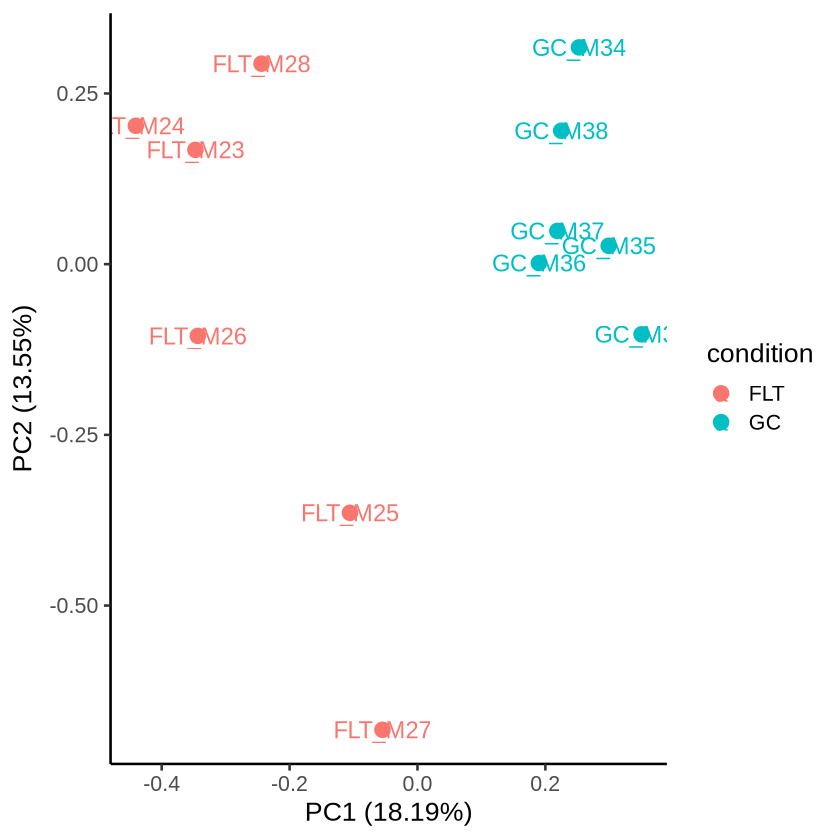

In [80]:
autoplot(PCA_raw, data=sampleTable, colour='condition', 
         label=TRUE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `autoplot()` - a function from the **ggplot2** package (typically used for visualizing PCA results). It automatically generates a plot based on the input object, which in this case is our PCA result.
  
  - `PCA_raw` - This is the variable holding the **PCA object** that we generated above, which contains the principal components of the log2 transformed raw gene expression data. The first two principal components (PC1 and PC2) will be plotted on the x and y axes, respectively.

  - `data=sampleTable` - Specifies the sample metadata information stored in the `sampleTable` variable we created above.
  > This information will be used to color-code the samples based on which treatment group (FLT or GC) they belong to. 

  - `colour='condition'` - This argument specifies that the points (samples) in the PCA plot will be colored according to the "condition" column in `sampleTable`.

  - `label=TRUE` - Instructions the `autoplot()` function to label each point using the sample names specified in the `sampleTable`.

  - `label.size=5` - Specifies the size of the _labels_ displayed on the PCA plot to be 5.

  - `size=4` - Specifies the size of the _points_ on the PCA plot to be 4.

  - `alpha=1` - Sets the _transparency_ of the points. This is a value between 0 and 1 such that `alpha=1` means the points are fully opaque, whereas lower values (e.g., `alpha=0.5`) would make the points semi-transparent.

- `+ theme_classic(base_size = 16)`
  - `theme_classic()` is a **ggplot2** theme function that gives the plot a classic, clean look (removing gridlines and simplifying axes).
  - `base_size=16` sets the _base font size_ of the plot, making all text (axis titles, labels, etc.) size 16 font.
 
</div>


Let's save our PCA plot, with all samples labeled, to our PCA directory defined in [Step 1a](#1a.-Setup-Directory-Paths) above using the `ggsave()` function. 
> You can adjust the width, height, and dpi of the saved plot until you're satisfied with how the PCA plot looks.

In [81]:
ggsave(file.path(pca_dir,'OSD-104_PCA_raw_wlabels.png'), width = 8.5, height = 6, dpi = 300)

The PCA plot with all samples labeled is a bit messy, don't you think?

Let's create another plot without the sample labels by indicating that the label is FALSE instead of TRUE, and save this plot again using `ggsave()`:

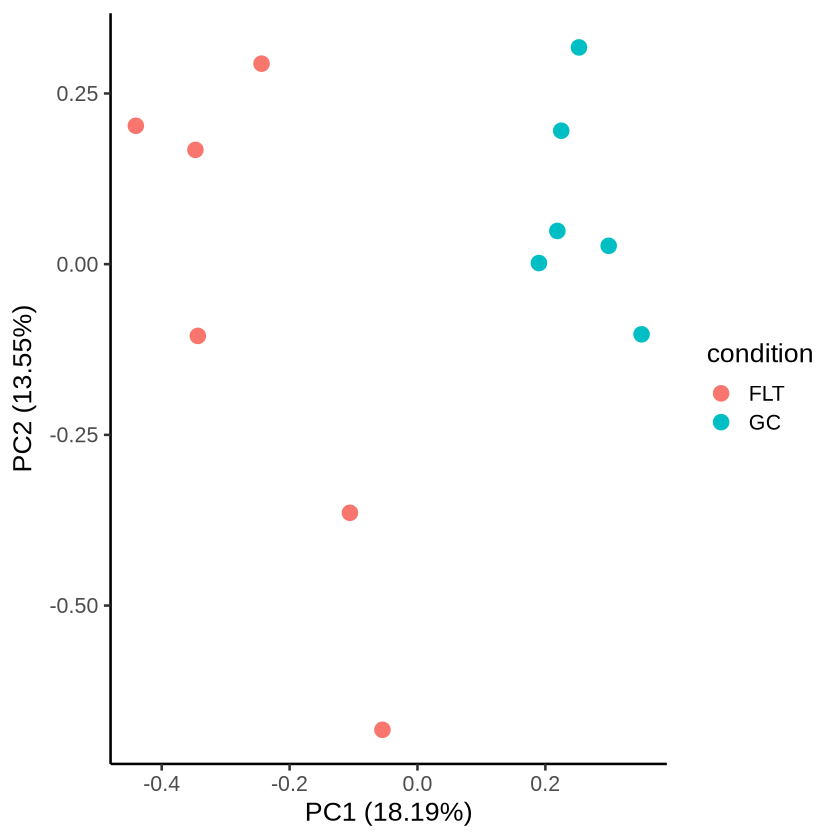

In [82]:
autoplot(PCA_raw, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save your PCA plot without sample labels
ggsave(file.path(pca_dir,'OSD-104_PCA_raw_nolabels.png'), width = 8.5, height = 6, dpi = 300)

<div class="alert alert-block alert-info">
<b>Note:</b><br>

Now that you know how to create plots with and without labels indicated, for the remaining PCA plots, we will only show the cleaner plots (without samples labeled). If you want to know which dot represents which sample, you are welcome to change the label back to TRUE in any of the plots we generate below.

</div>

**Take a look at the PCA plots we generated using the log2 transformed raw counts data and answer the following questions:**

1. Is there a pattern in how the samples are separating? 

2. Would you expect the data points to separate like this based on their biological conditions? Why or why not?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

Yes, the samples are separating by the FLT and GC conditions.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

Yes, I would expect the samples to separate like this since they are separating based on which treatment they received, flown in space (FLT) or kept on Earth (GC).

</details>
</div>

<br>

---

**We are now ready to begin the DESeq2 analysis, which is composed of 3 steps.**

<a class="anchor" id="sizefactor"></a>
## 2b. DESeq2 Step 1: Size Factor Estimation

In this first step, called size factor estimation, the algorithm corrects for the sample-wise differences in read depth we observed in [step 2c of the RNAseq processing JN](01-RNAseq_processing.ipynb#trimmedmultiqc).

The `estimateSizeFactors()` function provided by DESeq2 performs RNA-seq read depth normalization using the median of ratios method on the DESeqDataSet Object, `dds` that we made in [step 1c](#1c.-Make-DESeqDataSet-Object) above. 
> For additional information and training about the DESeq2 median of ratios method, visit [this HBC training](https://hbctraining.github.io/DGE_workshop/lessons/02_DGE_count_normalization.html).

<div class="alert alert-block alert-info">
<b>Median of ratios method</b><br>

1. A pseudo-reference sample is created for each gene, which is equal to the geometric mean of that gene's expression (count) across all samples.
2. For each gene in a sample, the gene expression for that sample is divided by the gene expression for the pseudo-reference sample to create a ratio (sample/pseudo-reference) for each gene in each sample.
3. The median value of all ratios for each sample is then extracted and used as the normalization factor (aka size factor) for that sample.
4. Lastly, each raw gene count value in each sample is divided by that sample's normalization factor to generate the normalized expression (count) values for all genes for all samples.

</div>

In [83]:
dds_1 <- estimateSizeFactors(dds)

using 'avgTxLength' from assays(dds), correcting for library size



<a class="anchor" id="dispersions"></a>
## 2c. DESeq2 Step 2: Estimate Gene Dispersions

Now that our count data are size-normalized, let's move on to the next step in the DESeq2 program: estimating gene dispersions then shrinking the gene-wise dispersion estimates toward the expected dispersion values. 

The _dispersion_ of a gene is a measure of the spread or variability of that gene's expression in a dataset. We are interested in calculating the dispersion of each gene to understand whether there is unexpected variability in our dataset, which may be due to technical artifacts, and then correct for it.

`DESeq2` measures dispersion as it relates the mean and variance of the data such that DESeq2 dispersion estimates are inversely related to the mean and directly related to variance. Thus, the dispersion is higher for small mean counts and lower for large mean counts. 

The `estimateDispersions()` function provided by DESeq2 calculates the gene-wise dispersions and then shrinks them in order to model the size-normalized counts for each gene.
> For additional information and training on how DESeq2 estimates gene dispersions and performs shrinkage, visit [this HBC training](https://hbctraining.github.io/DGE_workshop/lessons/04_DGE_DESeq2_analysis.html).

<div class="alert alert-block alert-info">
<b>Estimate gene dispersions and perform shrinkage</b><br>

We first need to generate accurate estimates of within-group variation (i.e. variation between biological replicates of the same treatment group) for each gene. However, since there are a small number of replicates per group (6 in our dataset), the estimates of variation for each gene are often unreliable, especially for genes with smaller means (due to the large differences in dispersion for lower expressing genes). To address this issue, DESeq2 _shares information across genes_ to generate more accurate estimates of variation based on the mean expression level of the gene.
  > Using this approach, referred to as "shrinkage", DESeq2 assumes that genes with similar expression levels have similar dispersion/variance.

1. **Estimate gene-wise dispersion**: The dispersion for each gene is estimated using maximum likelihood estimation (MLE). This means that the most likely estimate of dispersion is calculated for each gene, given the gene expression values (aka gene counts) from all the replicates in each group.

2. **Generate estimation curve**: Next, the size-normalized count value of each gene is plotted against the MLE of the dispersion for that gene for all genes in all sample groups. The values on that plot are used to generate a curve that represents the estimate for the expected dispersion value for genes of a given expression strength (count value).

3. **Shrink gene-wise dispersion estimates**: Finally, the gene-wise dispersion estimates are shrunk towards the expected dispersion values predicted by the curve.
  > The strength of the shrinkage for each gene depends on:
  > - how close the gene dispersion is from the curve
  > - sample size (more samples = less shrinkage)

Genes with low dispersion estimates are shrunken towards the curve and genes with dispersion estimates slightly above the curve are also shrunked towards the curve for better dispersion estimation of these genes. However, genes with extremely high dispersion values are not shrunken because these genes likely do not follow the DESeq2 modeling assumptions and have higher variability than the others for biological or technical reasons.
> Note: Shrinking these values toward the curve could result in false positives, which is why they are not shrunken. _These exceptionally high variability genes are shown as black dots surrounded by blue circles in the plot we will look at below._
 
**This shrinkage method is particular important to reduce false positives in the DGE analysis we will perform below.**

</div>


In [84]:
dds_1 <- estimateDispersions(dds_1)

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



**Visualize gene-wise dispersion estimates**

Let's take a look at the relationship between the expression of each gene and the gene dispersion estimates we calculated above by plotting these values with the `plotDispEsts()` function: 

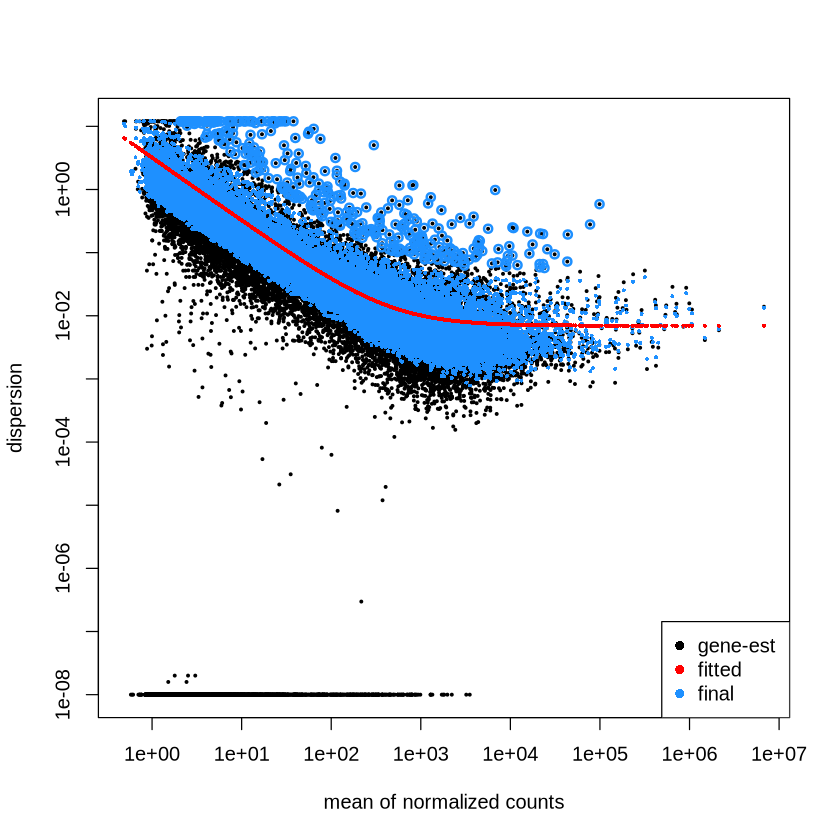

In [86]:
plotDispEsts(dds_1)

**Use the plot above to answer the following questions:**

1. What is the relationship between gene dispersion and mean expression of a gene? What does this tell you about RNA sequencing data? 
2. How do the gene expression data change before (black dots) and after (blue dots) fitting gene dispersion estimates using the shrinkage method?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

As gene expression (counts shown on the x-axis) increases, dispersion (on the y-axis) decreases.

This tells us that RNAseq data are noisy for low expressing genes.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The dispersion of the gene expression data gets closer to the expected dispersion value for each gene expression level after shrinkage.

</details>
</div>

<br>

---


<a class="anchor" id="wald"></a>
## 2d. DESeq2 Step 3: Hypothesis Testing with Wald Test

Finally, we are ready to proceed to the third and final step of the DESeq2 process, hypothesis testing. Hypothesis testing will tell us the probability of each gene's expression being significantly different in one of our groups of interest (FLT/GC).

We will perform our hypothesis testing using the Wald test, which is similar to a T-test. Recall from the "GL4U RNAseq Statistics Overview" lecture that the Wald test needs to know the type of data distribution to use to build a mathematical model suitable for hypothesis testing. RNAseq data most closely mimics a negative binomial distribution, where the majority of genes have an expression value close to zero with some genes having higher expression values.

Therefore, we will use the `nbinomWaldTest()` function provided by DESeq2 to fit a negative binomial model to the gene expression data and perform hypothesis testing using the Wald test. 

<div class="alert alert-block alert-info">
<b>Negative binomial Wald test</b><br>

The DESeq2 `nbinomWaldTest()` function will calculate a Wald statistic for each gene as shown below, along with a probability value (p-value) of the test. If the p-value is small, we reject the null hypothesis and state that there is evidence against the null (i.e. the gene is differentially expressed).
> Note: The null hypothesis we are testing is that the gene does not change expression significantly between the two groups.

$$
W = \frac{\hat{\beta}}{\text{SE}(\hat{\beta})}
$$

Where:
- $W$: The Wald statistic
- $\hat{\beta}$: The estimated log2 fold change (LFC) for the gene between the two conditions (e.g. FLT and GC).
- $\text{SE}(\hat{\beta})$: The standard error of the LFC estimate calculated as follows:
  $$
  \text{SE}(\hat{\beta}) = \sqrt{\text{Var}(\hat{\beta})}
  $$
  Where:
  - $\text{Var}(\hat{\beta})$ is the estimated variance of the LFC.
  
</div>

**Multiple tests correction**

Recall from the "GL4U RNAseq Statistics Overview" lecture that the more genes we test, the more we inflate the false positive rate, which is know as the multiple testing problem. 
> E.g. If we test 20,000 genes for DE defined as p < 0.05, we would expect to find 1,000 genes by chance. If we found 2,000 DEGs in total, about one half of our genes are likely false positives.

To reduce the number of false positives, in DESeq2, the p-values attained by the Wald test are corrected for multiple testing using the Benjamini and Hochberg (BH) method, by default, to generate an adjusted p-value for each gene. 
> **The adjusted p-values should be used to determine significant DEGs.**

<div class="alert alert-block alert-info">
<b>BH method to adjust for FDR</b><br>

In DESeq2, the BH method for controlling the FDR is implemented by ranking the genes by p-value then multiplying each ranked p-value by the ratio of the number of genes tested divided by the rank for that gene, as shown below:

$$
\text{Adjusted p-value} = \text{p-value} \times \frac{m}{\text{rank}}
$$

Where:
- $m$: The total number of genes (i.e. total tests).
- $\text{rank}$: The rank of the gene's p-value after sorting the genes by their p-values.

</div>

In [87]:
dds_1 <- nbinomWaldTest(dds_1)

Run the following command to store the normalized gene counts as a matrix represented by the variable `normCounts`:

In [88]:
normCounts = as.data.frame(counts(dds_1, normalized=TRUE))

**Answer the following questions:**

1. Is the Wald test the only type of hypothesis testing method we could have used here? (Hint: see the "Likelihood ratio test" section here: http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) 
2. Why did we choose the Wald test?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

No, the Wald test is not the only type of hypothesis testing method we could have used. The likelihood ratio test (LRT) is another option.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

We choose to use the Wald test because we are comparing two groups.

</details>
</div>

<br>

<div class="alert alert-block alert-info">
<b>Note:</b><br>

Although we do not calculate the likelihood ratio test (LRT) in this tutorial, since there are several RNAseq datasets on OSDR that contain more than 2 groups, the current GeneLab pipeline also runs the LRT to generate the F-statistic p-value, which is similar to an ANOVA p-value, and the F-statistic adjusted p-value. 
> _Only the F-statistic adjusted p-value is reported in the "LRT.p.value" column of the GeneLab differential_expression.csv file._

</div>

<br>

#### **PCA of normalized count data**

Now that we've normalized our count data, let's perform principal component analysis (PCA) of our normalized count data using the commands described in [step 2a](#2a.-PCA-of-Raw,-Unnormalized-Count-Data) above.

We'll start by log2 transforming our normalized count data then we'll calculate the principal components:

In [89]:
## Add 1 to every gene count then log2 transform the normalized counts data ##
exp_norm <- log2(normCounts+1)

## Calculate the principal components of the normalized counts data ##
PCA_norm <- prcomp(t(exp_norm), scale = FALSE)

We're now ready to plot PC1 vs. PC2 (without labels) then save our plot with `ggsave()`:

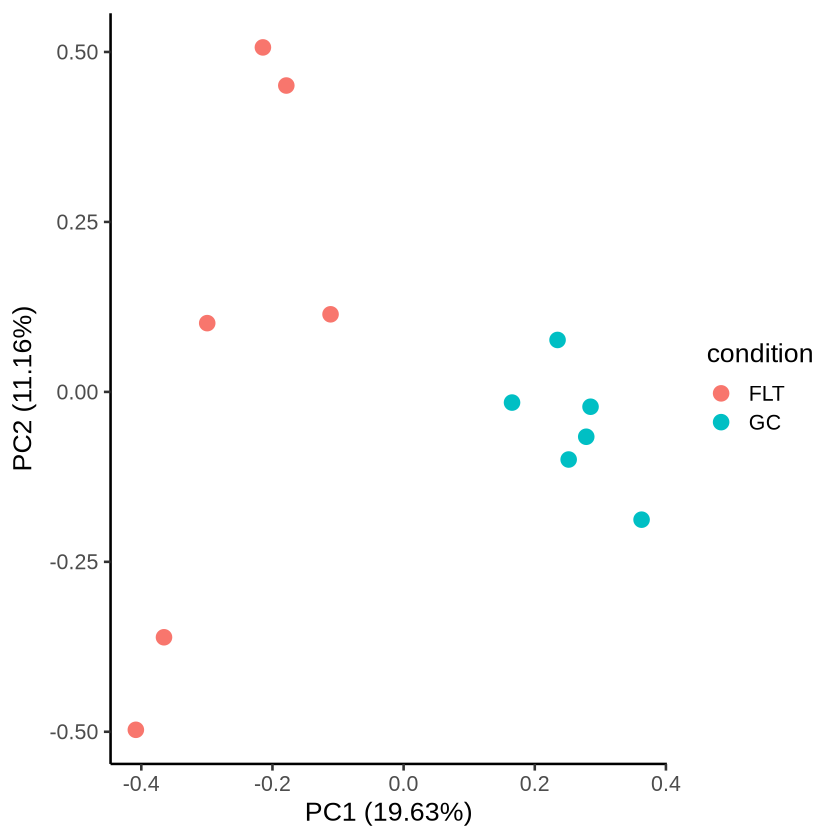

In [90]:
autoplot(PCA_norm, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save the PCA plot (without sample labels)
ggsave(file.path(pca_dir,'OSD-104_PCA_norm_nolabels.png'), width = 8.5, height = 6, dpi = 300)

**Look at the PCA plots before and after normalization, and answer the following questions:**

1. Is the percent of variance explained by PC2 more or less after normalization? Does that tell you anything about what was contributing to the differences in PC2?
   
2. How has the within-group variation changed? Why do you think that is?

3. How has the percent of variance explained by PC1 changed? What does this mean? 

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The percent of variance explained by PC2 is less after normalization.

This suggests that some of the differences among samples observed in the raw count data were driven by technical differences between samples that have been corrected for upon normalization.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The within group variation is now smaller, i.e. the FLT samples are closer together and the GC samples are closer together than they were using the raw count data.

This suggests that some of the differences among samples within the same group were due to technical artifacts.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

The percent of variance explained by PC1 has increased.

This suggests that the differences explained by PC1, which appears represent the biological signal (i.e. the differences between the two groups) became stronger after normalizing for technical differences. 

</details>
</div>


<br>

---

**Challenge:** Use the next few code blocks to 1) list the number of PCs after normalization and 2) recreate the PCA plot but adjust these parameters: size, alpha (must be between 0 and 1). How does your plot change?
> Hint: 1) Use the `summary()` function we used in step 2a. 2) Fist copy the `autoplot()` command from the previous code block then change the parameters.

In [91]:
summary(PCA_norm)

Importance of components:
                           PC1     PC2      PC3      PC4      PC5     PC6
Standard deviation     41.5271 31.3138 29.38415 28.90054 27.06881 25.7905
Proportion of Variance  0.1963  0.1116  0.09827  0.09506  0.08339  0.0757
Cumulative Proportion   0.1963  0.3079  0.40613  0.50119  0.58458  0.6603
                            PC7      PC8      PC9     PC10     PC11      PC12
Standard deviation     25.31633 24.77727 24.48927 24.04911 23.49602 6.602e-14
Proportion of Variance  0.07294  0.06987  0.06825  0.06582  0.06283 0.000e+00
Cumulative Proportion   0.73322  0.80309  0.87135  0.93717  1.00000 1.000e+00

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

```R
summary(PCA_norm)
```

The number of PCs reported after normalization is 12.

</details>
</div>

<br>


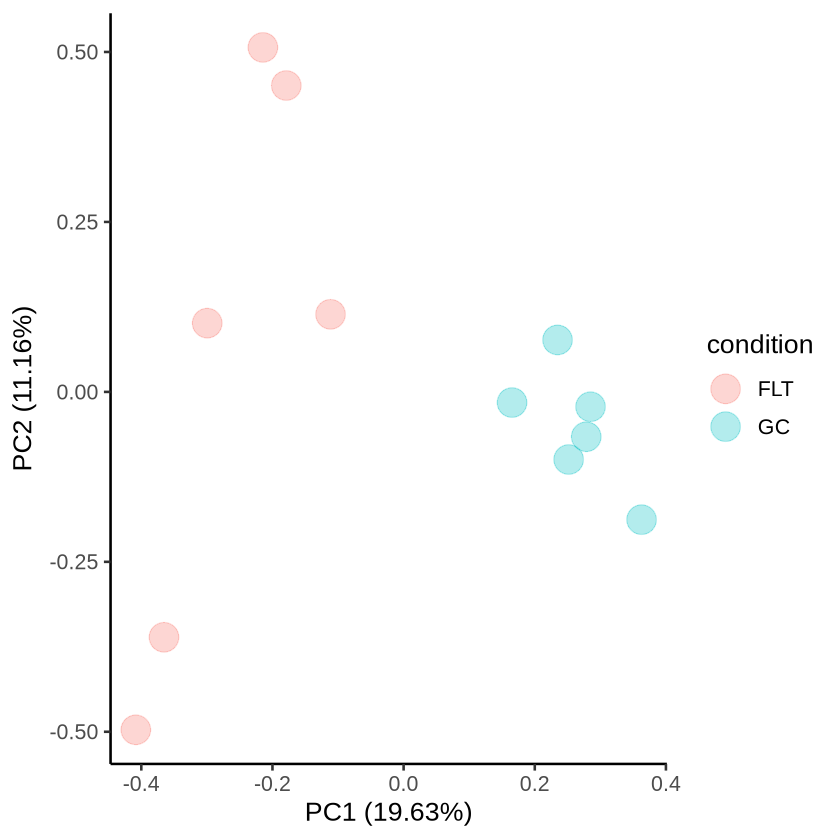

In [92]:
autoplot(PCA_norm, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=8, alpha=0.3) + theme_classic(base_size = 16) 

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

```R
autoplot(PCA_norm, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=8, alpha=0.3) + theme_classic(base_size = 16) 
```

The size of the dots changed and became more transparent.

</details>
</div>

<br>

---

<a class="anchor" id="dge"></a>
# 3. DGE Analysis

The results of the DESeq2 analysis we performed in [step 2](#2.-DESeq2-Data-Normalization) are currently stored in the `dds_1` object. In the next steps, we will create a differential gene expression (DGE) output table and use the `results()` function to extract the DESeq2 results and add them to table. We will start with our normalized counts table generated at the end of [Step 2d](#2d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test) above and add pair-wise comparison columns containing the FLT vs GC data from the Wald tests performed in [Step 2d](#2d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test). We will also perform calculations to generate columns containing all samples as well as group means and standard deviations and complete the table by adding gene annotations. 

<a class="anchor" id="calculations"></a>
## 3a. Perform Data Calculations and Create DGE Output Table

**Create DGE output table**

We'll start the DGE output table, held in the variable `DGE_output_table`, by adding the normalized gene count data from each sample created in [step 2d](#2d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test): 

In [93]:
DGE_output_table <- normCounts 

Take a look at the first 6 rows of our initial DGE table. 

In [94]:
options(repr.matrix.max.cols=150)
head(DGE_output_table)

,FLT_M23,FLT_M24,FLT_M25,FLT_M26,FLT_M27,FLT_M28,GC_M33,GC_M34,GC_M35,GC_M36,GC_M37,GC_M38
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,1019.469140,849.187206,818.00651,856.071352,909.61378,856.33198,1006.84054,915.94480,9.634610e+02,8.565871e+02,8.582016e+02,903.90124
ENSMUSG00000000028,105.163652,161.935783,89.10151,131.250485,162.61317,114.59797,122.83824,120.76892,1.078652e+02,1.109682e+02,1.284019e+02,136.11563
ENSMUSG00000000031,80034.723556,76000.057440,84150.40809,89062.076738,60629.92136,68894.66696,122134.68956,106327.89967,1.146058e+05,1.139242e+05,1.057680e+05,117356.02181
ENSMUSG00000000037,7.269821,8.569119,6.97913,7.595337,12.68365,11.05948,18.96433,11.50395,7.275586e+00,5.158986e+00,2.593421e+00,14.13879
ENSMUSG00000000049,10.927138,11.189219,19.06568,31.856822,51.27453,10.34551,19.45968,11.72621,9.078323e+00,6.610977e+00,1.235054e+01,10.03215
ENSMUSG00000000056,4456.338957,4703.653103,4549.41005,4727.066330,4260.16360,4512.56577,5326.25681,5393.30721,5.033712e+03,5.384166e+03,5.050690e+03,5444.75680


<div class="alert alert-block alert-info">
<b>Note:</b><br>

The DGE output table currently has 12 columns (1 for each sample), and the rows are genes represented here by the ENSEMBL mouse gene IDs.

</div>

**Add pairwise comparison columns**

Next we'll iterate through the results of the Wald tests to generate pairwise comparison columns for each contrast listed in our `contrasts` table.

Let's first take a look at the contrasts we set up in [step 1b](#1b.-Import-the-Data):

In [95]:
contrasts

(FLT)v(GC),(GC)v(FLT)
FLT,GC
GC,FLT


We want to iterate through both of those contrasts (FLT vs. GC and GC vs. FLT) and report the log2 fold change, Wald statistic, p-value, and adjusted p-value from the Wald tests we performed in [Step 2d](#2d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test).

In [96]:
for (i in 1:dim(contrasts)[2]){
   res_1 <- results(dds_1, contrast=c("condition",contrasts[1,i],contrasts[2,i]))  
	res_1 <- as.data.frame(res_1@listData)[,c(2,4,5,6)]  
	colnames(res_1) <-c(paste0("Log2fc_",colnames(contrasts)[i]),
                        paste0("Stat_",colnames(contrasts)[i]),
                        paste0("P.value_",colnames(contrasts)[i]),
                        paste0("Adj.p.value_",colnames(contrasts)[i]))  
	DGE_output_table <- cbind(DGE_output_table,res_1)  
}

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `for (i in 1:dim(contrasts)[2]){}`:  
  - This is a _for loop_ that iterates over each column of the `contrasts` matrix.
  - `dim(contrasts)[2]` returns the number of columns in the `contrasts` matrix, meaning the loop will iterate from 1 to the total number of contrasts.
  - **`i`** represents the index of the current contrast column being processed.

- `res_1 <- results(dds_1, contrast=c("condition", contrasts[1,i], contrasts[2,i]))`:  
  - This line uses the `results()` function from DESeq2 to obtain the differential expression results for a specific contrast.
  - `dds_1`: The DESeqDataSet object that contains the DESeq2 results.
  - `contrast=c("condition", contrasts[1,i], contrasts[2,i])`: This specifies the contrast for the condition being tested. It extracts the values from the `contrasts` matrix for the current iteration, where:
    - `contrasts[1,i]`: The first level of the condition being compared.
    - `contrasts[2,i]`: The second level of the condition being compared.
  - The `results()` function returns an object containing p-values, log2 fold changes, and other statistical results that is stored in the `res_1` variable.

- `res_1 <- as.data.frame(res_1@listData)[,c(2,4,5,6)]`:  
  - Converts the `results` object (which is an S4 object) to a _data frame_ by accessing its `listData` slot.
  - `[,c(2,4,5,6)]`: Selects specific columns from the `listData`, which are:
    - Column 2: Log2 fold change (log2FC).
    - Column 4: Wald statistic (Stat).
    - Column 5: Raw p-value (P.value).
    - Column 6: Adjusted p-value (Adj.p.value).

- `colnames(res_1) <- c(paste0("Log2fc_", colnames(contrasts)[i]), paste0("Stat_", colnames(contrasts)[i]), paste0("P.value_", colnames(contrasts)[i]), paste0("Adj.p.value_", colnames(contrasts)[i]))`:  
  - Renames the columns in `res_1` using the `paste0()` function, which concatenates strings.
  - The column names for each result are customized based on the contrast currently being evaluated (`colnames(contrasts)[i]`). For example:
    - `"Log2fc_"` will be followed by the name of the contrast for that column.
    - `"Stat_"`, `"P.value_"`, and `"Adj.p.value_"` follow the same pattern for the corresponding statistics.

- `DGE_output_table <- cbind(DGE_output_table, res_1)`:  
  - `cbind()` (column bind) appends the results (`res_1`) as new columns to the existing DGE output table (`DGE_output_table`).

> Note: The loop will iteratively add new sets of results for each contrast, appending them as additional columns to the `DGE_output_table`.

</div>

<br>

**Add mean and standard deviation columns**

For each gene, we will calculate the mean expression and standard deviation across all samples and add these calculations to the DGE output table.

In [97]:
DGE_output_table$All.mean <- rowMeans(normCounts, na.rm = TRUE, dims = 1)
DGE_output_table$All.stdev <- rowSds(as.matrix(normCounts), na.rm = TRUE, dims = 1)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `DGE_output_table$All.mean <- rowMeans(normCounts, na.rm = TRUE, dims = 1)`:
  - `DGE_output_table$All.mean`: This creates a new column in the `DGE_output_table` data frame called `All.mean`, which will store the mean of each row (gene) across all samples.
  - `rowMeans(normCounts, na.rm = TRUE, dims = 1)`:
    - `rowMeans()`: A base R function that calculates the _mean_ for each row in a matrix or data frame.
    - `normCounts`: This is the matrix that contains the normalized counts for each gene (rows) across all samples (columns).
    - `na.rm = TRUE`: Specifies that missing values (`NA`) should be removed before calculating the means.
      > _Note: If this is set to `FALSE`, the presence of `NA` values would cause the mean to return `NA`._
    - `dims = 1`: This specifies that the function should calculate means along rows (genes), not columns.
      > _Note: In `rowMeans()`, `dims = 1` is the default and ensures the function operates row-wise._

- `DGE_output_table$All.stdev <- rowSds(as.matrix(normCounts), na.rm = TRUE, dims = 1)`:
  - `DGE_output_table$All.stdev`: This creates a new column in the `DGE_output_table` data frame called `All.stdev`, which will store the standard deviation of each row (gene) across all samples.
  - `rowSds(as.matrix(normCounts), na.rm = TRUE, dims = 1)`:
    - `rowSds()`: A function from the _matrixStats_ package that calculates the _standard deviation_ for each row in a matrix.
    - `as.matrix(normCounts)`: Converts the `normCounts` object into a matrix (if it is not already a matrix) because the `rowSds()` function requires a matrix as input.
    - `na.rm = TRUE`: Ensures that any missing values (`NA`) are removed before calculating the standard deviation.
    - `dims = 1`: This specifies that the function should calculate standard deviations along rows (genes), which is the default for `rowSds()`.

</div>

<br>

**Challenge:** Use the code block below to look at the first 6 rows of the DGE output table now. 

> Hint: Use the head() function we used at the beginning of this step (3a).

In [98]:
head(DGE_output_table)

,FLT_M23,FLT_M24,FLT_M25,FLT_M26,FLT_M27,FLT_M28,GC_M33,GC_M34,GC_M35,GC_M36,GC_M37,GC_M38,Log2fc_(FLT)v(GC),Stat_(FLT)v(GC),P.value_(FLT)v(GC),Adj.p.value_(FLT)v(GC),Log2fc_(GC)v(FLT),Stat_(GC)v(FLT),P.value_(GC)v(FLT),Adj.p.value_(GC)v(FLT),All.mean,All.stdev
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,1019.469140,849.187206,818.00651,856.071352,909.61378,856.33198,1006.84054,915.94480,9.634610e+02,8.565871e+02,8.582016e+02,903.90124,-0.05347980,-0.7980902,4.248182e-01,6.219642e-01,0.05347980,0.7980902,4.248182e-01,6.219642e-01,901.134687,65.251114
ENSMUSG00000000028,105.163652,161.935783,89.10151,131.250485,162.61317,114.59797,122.83824,120.76892,1.078652e+02,1.109682e+02,1.284019e+02,136.11563,0.07490631,0.4857526,6.271426e-01,7.828666e-01,-0.07490631,-0.4857526,6.271426e-01,7.828666e-01,124.301724,21.848244
ENSMUSG00000000031,80034.723556,76000.057440,84150.40809,89062.076738,60629.92136,68894.66696,122134.68956,106327.89967,1.146058e+05,1.139242e+05,1.057680e+05,117356.02181,-0.56801131,-6.7356304,1.632207e-11,5.266460e-10,0.56801131,6.7356304,1.632207e-11,5.266460e-10,94907.369231,20940.355678
ENSMUSG00000000037,7.269821,8.569119,6.97913,7.595337,12.68365,11.05948,18.96433,11.50395,7.275586e+00,5.158986e+00,2.593421e+00,14.13879,-0.16001195,-0.3419056,7.324219e-01,8.524599e-01,0.16001195,0.3419056,7.324219e-01,8.524599e-01,9.482633,4.420898
ENSMUSG00000000049,10.927138,11.189219,19.06568,31.856822,51.27453,10.34551,19.45968,11.72621,9.078323e+00,6.610977e+00,1.235054e+01,10.03215,0.98902600,2.1561964,3.106833e-02,9.902057e-02,-0.98902600,-2.1561964,3.106833e-02,9.902057e-02,16.993065,12.754243
ENSMUSG00000000056,4456.338957,4703.653103,4549.41005,4727.066330,4260.16360,4512.56577,5326.25681,5393.30721,5.033712e+03,5.384166e+03,5.050690e+03,5444.75680,-0.21757558,-5.6560759,1.548730e-08,3.080695e-07,0.21757558,5.6560759,1.548730e-08,3.080695e-07,4903.507233,420.428906


<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

```R
head(DGE_output_table)
```

</details>
</div>

<br>

**Looking at the DGE output table now and answer the following questions:**
1. How many columns have been added?
   
2. What is the average expression of gene, ENSMUSG00000000031 across all samples?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

10 columns have been added to the DGE table.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The average expression of gene ENSMUSG00000000031 across all samples is: 94907.369231

</details>
</div>

<br>

Next, we'll calculate the mean expression for each gene across samples within each group, and add group means to the `DGE_output_table`.

In [99]:
tcounts <- as.data.frame(t(normCounts))
tcounts$group <- group
group_means <- as.data.frame(t(aggregate(. ~ group,data = tcounts,mean)))
group_means <- group_means[-c(1),]
colnames(group_means) <- paste0("Group.Mean_",levels(factor(names(group))))

DGE_output_table <- cbind(DGE_output_table,group_means)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `tcounts <- as.data.frame(t(normCounts))`:  
  - `t(normCounts)`: Transposes the `normCounts` matrix so that rows become columns and columns become rows.
    > - _Before transposing_: Rows represent genes and columns represent samples.
    > - _After transposing_: Rows now represent samples, and columns represent genes.
  - `as.data.frame()`: Converts the transposed matrix into a data frame called `tcounts`, so it can be manipulated more easily in subsequent steps.

- `tcounts$group <- group`:  
  - Adds a new column titled "group" to the `tcounts` data frame, that specifies which group each sample belongs to using the `group` variable created in [step 1b](#1b.-Import-the-Data) above.

- `group_means <- as.data.frame(t(aggregate(. ~ group, data = tcounts, mean)))`:  
  - `aggregate(. ~ group, data = tcounts, mean)`: Calculates the _mean_ of each gene for each group in `tcounts`:
    - `~ group`: Specifies that the data should be grouped by the `group` variable.
    - `.`: Refers to all other columns (genes) in `tcounts`.
    - `mean`: Computes the mean of each gene for each group.
  - `t()`: Transposes the resulting data frame (so that the group means for each gene are in columns, with rows representing genes).
  - `as.data.frame()`: Converts the transposed matrix into a data frame called `group_means`.

- `group_means <- group_means[-c(1),]`:  
  - Removes the first row from the `group_means` data frame, which is the `group` row created by the `aggregate()` function (which serves as metadata rather than gene data).
  - `[-c(1),]`: This removes the first row, keeping the remaining rows (gene expression means for each group).

- `colnames(group_means) <- paste0("Group.Mean_", levels(factor(names(group))))`:  
  - Renames the columns in `group_means` to reflect the group each mean belongs to:
    - `paste0("Group.Mean_", levels(factor(names(group)))`: Creates new column names by concatenating `"Group.Mean_"` with the group names.
    - `levels(factor(names(group)))`: Extracts the group names from the `group` variable.


- `DGE_output_table <- cbind(DGE_output_table, group_means)`:  
  - `cbind()`: Column-binds the `group_means` data frame to the `DGE_output_table`, adding the group-wise gene means as new columns in the DGE output table.

</div>

<br>

Now, we'll calculate the standard deviation for each gene across samples within each group, and add group standard deviations to the `DGE_output_table`.

In [100]:
group_stdev <- as.data.frame(t(aggregate(. ~ group,data = tcounts,sd)))
group_stdev <- group_stdev[-c(1),]
colnames(group_stdev) <- paste0("Group.Stdev_",levels(factor(names(group))))

DGE_output_table <- cbind(DGE_output_table,group_stdev)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `group_stdev <- as.data.frame(t(aggregate(. ~ group, data = tcounts, sd)))`:  
  - This command is similar to the one above, but instead of calculating the mean, it calculates the _standard deviation_ (`sd`) of each gene for each group.
  - `aggregate(. ~ group, data = tcounts, sd)`: Aggregates the data by `group` and calculates the standard deviation for each gene.
  - `as.data.frame(t())`: Transposes and converts the result into a data frame called `group_stdev`.

- `group_stdev <- group_stdev[-c(1),]`:  
  - Removes the first row of the `group_stdev` data frame, similar to how it was done for `group_means`, since the first row is the metadata for `group`.

- `colnames(group_stdev) <- paste0("Group.Stdev_", levels(factor(names(group))))`:  
  - Renames the columns in `group_stdev` to reflect the group each standard deviation belongs to:
    - `paste0("Group.Stdev_", levels(factor(names(group)))`: Creates new column names by concatenating `"Group.Stdev_"` with the group names.


- `DGE_output_table <- cbind(DGE_output_table, group_stdev)`:  
  - `cbind()`: Similarly, column-binds the `group_stdev` data frame to the `DGE_output_table`, adding the group-wise gene standard deviations as new columns.

</div>

<br>

**Use the code block below to look at the DGE output table now and answer the following questions:** 

In [101]:
DGE_output_table 

,FLT_M23,FLT_M24,FLT_M25,FLT_M26,FLT_M27,FLT_M28,GC_M33,GC_M34,GC_M35,GC_M36,GC_M37,GC_M38,Log2fc_(FLT)v(GC),Stat_(FLT)v(GC),P.value_(FLT)v(GC),Adj.p.value_(FLT)v(GC),Log2fc_(GC)v(FLT),Stat_(GC)v(FLT),P.value_(GC)v(FLT),Adj.p.value_(GC)v(FLT),All.mean,All.stdev,Group.Mean_(FLT),Group.Mean_(GC),Group.Stdev_(FLT),Group.Stdev_(GC)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
ENSMUSG00000000001,1019.469140,849.187206,8.180065e+02,856.071352,909.613776,856.331978,1.006841e+03,9.159448e+02,9.634610e+02,8.565871e+02,8.582016e+02,9.039012e+02,-0.05347980,-0.79809015,4.248182e-01,6.219642e-01,0.05347980,0.79809015,4.248182e-01,6.219642e-01,901.134687,65.251114,884.7800,917.4894,72.27296,59.17461
ENSMUSG00000000028,105.163652,161.935783,8.910151e+01,131.250485,162.613172,114.597965,1.228382e+02,1.207689e+02,1.078652e+02,1.109682e+02,1.284019e+02,1.361156e+02,0.07490631,0.48575265,6.271426e-01,7.828666e-01,-0.07490631,-0.48575265,6.271426e-01,7.828666e-01,124.301724,21.848244,127.4438,121.1597,30.24111,10.58027
ENSMUSG00000000031,80034.723556,76000.057440,8.415041e+04,89062.076738,60629.921365,68894.666965,1.221347e+05,1.063279e+05,1.146058e+05,1.139242e+05,1.057680e+05,1.173560e+05,-0.56801131,-6.73563041,1.632207e-11,5.266460e-10,0.56801131,6.73563041,1.632207e-11,5.266460e-10,94907.369231,20940.355678,76461.98,113352.76,10380.468,6354.878
ENSMUSG00000000037,7.269821,8.569119,6.979130e+00,7.595337,12.683651,11.059478,1.896433e+01,1.150395e+01,7.275586e+00,5.158986e+00,2.593421e+00,1.413879e+01,-0.16001195,-0.34190564,7.324219e-01,8.524599e-01,0.16001195,0.34190564,7.324219e-01,8.524599e-01,9.482633,4.420898,9.026090,9.939177,2.325632,6.090053
ENSMUSG00000000049,10.927138,11.189219,1.906568e+01,31.856822,51.274529,10.345508,1.945968e+01,1.172621e+01,9.078323e+00,6.610977e+00,1.235054e+01,1.003215e+01,0.98902600,2.15619644,3.106833e-02,9.902057e-02,-0.98902600,-2.15619644,3.106833e-02,9.902057e-02,16.993065,12.754243,22.44315,11.54298,16.35173,4.38273
ENSMUSG00000000056,4456.338957,4703.653103,4.549410e+03,4727.066330,4260.163597,4512.565775,5.326257e+03,5.393307e+03,5.033712e+03,5.384166e+03,5.050690e+03,5.444757e+03,-0.21757558,-5.65607593,1.548730e-08,3.080695e-07,0.21757558,5.65607593,1.548730e-08,3.080695e-07,4903.507233,420.428906,4534.866,5272.148,171.9109,182.1234
ENSMUSG00000000058,1183.686115,842.329144,7.286299e+02,863.061787,812.456408,760.186552,9.113577e+02,7.940644e+02,7.547669e+02,9.681508e+02,8.467583e+02,7.771971e+02,0.03720972,0.33123908,7.404639e-01,8.576811e-01,-0.03720972,-0.33123908,7.404639e-01,8.576811e-01,853.553761,124.631925,865.0583,842.0492,163.96465,83.49131
ENSMUSG00000000078,3076.440969,2582.738087,2.594269e+03,2025.700692,2249.112272,2018.286480,2.569827e+03,3.441767e+03,2.980555e+03,2.382677e+03,2.593389e+03,3.006970e+03,-0.22262308,-1.94073442,5.229050e-02,1.466490e-01,0.22262308,1.94073442,5.229050e-02,1.466490e-01,2626.811093,434.556704,2424.425,2829.198,408.3379,387.8176
ENSMUSG00000000085,2022.181038,1796.544537,2.016242e+03,2091.541745,1809.665937,2015.456948,1.914775e+03,1.910772e+03,1.859406e+03,1.822118e+03,1.777134e+03,1.693796e+03,0.09777711,1.82063633,6.866216e-02,1.792257e-01,-0.09777711,-1.82063633,6.866216e-02,1.792257e-01,1894.135979,121.570677,1958.605,1829.667,123.86659,84.83339


1. How many columns have been added?
  
2. What is the average expression of gene, ENSMUSG00000000031 in the FLT group? In the GC group?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

4 columns have been added to the DGE table.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The average expression of gene ENSMUSG00000000031:
In the FLT group: 76461.98
In the GC group: 113352.76

</details>
</div>

<br>

---

<a class="anchor" id="annotations"></a>
## 3b. Add Gene Annotations 

Looking at the first column of our DGE table above, you'll notice that the genes are listed as ENSEMBL mouse gene IDs, which doesn't really mean much to anyone unless you have a list of which gene each ENSEMBL ID represents. Since gene names can be long, it may also be useful to know which gene symbol corresponds to each ENSEMBL ID. Furthermore, depending on what downstream analyses you want to run, having a list of IDs from other databases such as RefSeq, Entrez, and/or GOSLIM may be required. Therefore, in this step, we will run a series of commands to add columns to our DGE output table containing other gene identifiers that correspond to the respective ENSEMBL ID.

<div class="alert alert-block alert-info">
<b>Note:</b><br>

The current GeneLab pipeline appends annotations to DGE output tables using pre-built annotation tables described in the [GeneLab Reference Annotations](https://github.com/nasa/GeneLab_Data_Processing/tree/master/GeneLab_Reference_Annotations) pipeline. However, for training purposes, we will walk through how to iteratively add these annotation columns below.

</div>


**Define the organism**

We will start by defining the organism used in the study with the respecitve identifiers found in the various databases we will extract annotations from:

<div class="alert alert-block alert-info">
<b>Note:</b><br>

- The `organism` identifier specified must match the "Short Name" for that organism in the [PANTHER database](https://www.pantherdb.org/panther/summaryStats.jsp).
  > In this JN we use [PANTHER database version 18.0](https://archive.pantherdb.usc.edu/panther/summaryStats.jsp) 
- The `ann.dbi` identifier specified must match the [Bioconductor annotation package](https://www.bioconductor.org/packages/release/BiocViews.html#___AnnotationData) for the organism. Be sure to use the package with the "Bioconductor Package Maintainer" listed in the "Maintainer" column.
  > In this JN we use [Bioconductor version 3.19 AnnotationData Packages](https://bioconductor.org/packages/3.19/data/annotation/)
- The `taxonid` identifier specified must match the NCBI taxonomy ID for the organism, which can be searched for in the [NCBI taxonomy browser](https://www.ncbi.nlm.nih.gov/taxonomy/).

</div>


In [102]:
organism <- "MOUSE"
ann.dbi <- "org.Mm.eg.db"
taxonid <- 10090

**Create annotation table**

We'll begin building an annotation table for the organism used in this study (mouse) by pulling in annotations found in the `org.Mm.eg.db` Bioconductor annotation package: 
> _Note: These annotations are added using the ENSEMBL mouse gene IDs as the keytype._

In [103]:
keytype <- "ENSEMBL"
annot <- data.frame(rownames(DGE_output_table), stringsAsFactors = FALSE)
colnames(annot)[1]<-keytype
if ("SYMBOL" %in% columns(eval(parse(text = ann.dbi),env=.GlobalEnv))){
	annot$SYMBOL<-mapIds(eval(parse(text = ann.dbi),env=.GlobalEnv),
                         keys = rownames(DGE_output_table),
                         keytype = keytype, 
                         column = "SYMBOL", 
                         multiVals = "first")
}
if ("GENENAME" %in% columns(eval(parse(text = ann.dbi),env=.GlobalEnv))){
        annot$GENENAME<-mapIds(eval(parse(text = ann.dbi),env=.GlobalEnv),
                               keys = rownames(DGE_output_table),
                               keytype = keytype, 
                               column = "GENENAME", 
                               multiVals = "first")
}
if ("ENSEMBL" %in% columns(eval(parse(text = ann.dbi),env=.GlobalEnv))){
        annot$ENSEMBL<-mapIds(eval(parse(text = ann.dbi),env=.GlobalEnv),
                              keys = rownames(DGE_output_table),
                              keytype = keytype, 
                              column = "ENSEMBL", 
                              multiVals = "first")
}
if ("REFSEQ" %in% columns(eval(parse(text = ann.dbi),env=.GlobalEnv))){
        annot$REFSEQ<-mapIds(eval(parse(text = ann.dbi),env=.GlobalEnv),
                             keys = rownames(DGE_output_table),
                             keytype = keytype, 
                             column = "REFSEQ", 
                             multiVals = "first")
}
if ("ENTREZID" %in% columns(eval(parse(text = ann.dbi),env=.GlobalEnv))){
        annot$ENTREZID<-mapIds(eval(parse(text = ann.dbi),env=.GlobalEnv),
                               keys = rownames(DGE_output_table),
                               keytype = keytype, 
                               column = "ENTREZID", 
                               multiVals = "first")
}

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `keytype <- "ENSEMBL"`:
  - `keytype`: A variable that stores the type of gene identifier being used, which in this case is `"ENSEMBL"`. This defines how gene identifiers will be looked up in the annotation database.
  - `"ENSEMBL"`: Refers to Ensembl gene IDs (e.g., `ENSMUSG00000000001`), which are typically used as the main key for gene annotation mapping.

- `annot <- data.frame(rownames(DGE_output_table), stringsAsFactors = FALSE)`:
  - `rownames(DGE_output_table)`: Retrieves the row names of `DGE_output_table`, which are the gene IDs (in this case, Ensembl IDs).
  - `data.frame()`: Creates a new data frame called `annot` using the row names of `DGE_output_table` as the first column. The option `stringsAsFactors = FALSE` ensures that the gene identifiers are treated as strings (characters) rather than factors.
  - `annot`: This will be the annotation table where we will map additional gene annotations, like gene symbols.

- `colnames(annot)[1] <- keytype`:  
  - `colnames(annot)[1]`: Refers to the name of the first column in the `annot` data frame (currently containing Ensembl IDs).
  - `<- keytype`: Sets the name of this column to the value of `keytype` (which is `"ENSEMBL"`). This makes the column name `"ENSEMBL"` in the `annot` data frame.

- `if ("SYMBOL" %in% columns(eval(parse(text = ann.dbi), env = .GlobalEnv))){}`:  
  - `"SYMBOL" %in% columns(...)`: Checks whether the `"SYMBOL"` column exists in the annotation database. `"SYMBOL"` refers to the gene symbol (e.g., `Gnai3`).
  - `eval(parse(text = ann.dbi), env = .GlobalEnv)`: This evaluates the variable `ann.dbi` as an object within the global environment (`.GlobalEnv`).
    > _Note: `ann.dbi` holds the string "org.Mm.eg.db", which refers to the Bioconductor annotation database object for mouse._
  - `columns()`: Retrieves the available columns in the annotation database, including different types of gene identifiers (like `ENSEMBL`, `SYMBOL`, etc.).

- `annot$SYMBOL <- mapIds(eval(parse(text = ann.dbi), env = .GlobalEnv), keys = rownames(DGE_output_table), keytype = keytype, column = "SYMBOL", multiVals = "first")`:  
  - `annot$SYMBOL`: Creates a new column called `SYMBOL` in the `annot` data frame, which will store gene symbols corresponding to each Ensembl gene ID.
  - `mapIds()`: This function is used to map identifiers (e.g., Ensembl gene IDs) to another identifier type (e.g., gene symbols). It performs the actual mapping based on the specified database and parameters:
    - `eval(parse(text = ann.dbi), env = .GlobalEnv)`: Evaluates `ann.dbi` as the annotation database object from which gene IDs will be mapped.
    - `keys = rownames(DGE_output_table)`: The Ensembl gene IDs from `DGE_output_table` are provided as the keys to be mapped.
    - `keytype = keytype`: Specifies that the gene IDs are of type `"ENSEMBL"` (as defined by the `keytype` variable).
    - `column = "SYMBOL"`: Specifies that we want to retrieve the _gene symbols_ (`SYMBOL`) corresponding to each Ensembl gene ID.
    - `multiVals = "first"`: If a gene has multiple symbols, this ensures that only the first symbol is returned for each gene (to avoid returning multiple values for a single key).

> _Note: These same commands are used to extract "GENENAME", "REFSEQ", and "ENTREZID" IDs for each gene and add them as additional columns in the `annot` annotation table._

</div>

<br>

**Challenge:** Use the following code block to view the first 6 rows of our Gene Annotation table, `annot`.
> Hint: Use the `head()` function. 

In [104]:
head(annot)

,ENSEMBL,SYMBOL,GENENAME,REFSEQ,ENTREZID
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000000001,Gnai3,G protein subunit alpha i3,NM_010306,14679
2,ENSMUSG00000000028,Cdc45,cell division cycle 45,NM_001161623,12544
3,ENSMUSG00000000031,H19,"H19, imprinted maternally expressed transcript",NM_023123,14955
4,ENSMUSG00000000037,Scml2,Scm polycomb group protein like 2,NM_001290651,107815
5,ENSMUSG00000000049,Apoh,apolipoprotein H,NM_013475,11818
6,ENSMUSG00000000056,Narf,nuclear prelamin A recognition factor,NM_026272,67608


<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

```R
head(annot)
```

</details>
</div>

<br>


**Looking at the Gene Annotation table above, answer the following questions:**

1. How many different types of gene annotations does the table contain?
2. What is the gene name and symbol of ENSEMBL ID: ENSMUSG00000000028? What about ENSEMBL ID: ENSMUSG00000000031?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The table contains 5 different types of gene annotations.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

For ENSEMBL ID: ENSMUSG00000000028:
gene name = cell division cycle 45
symbol = Cdc45

For ENSEMBL ID: ENSMUSG00000000031:
gene name = H19, imprinted maternally expressed transcript
symbol = H19


</details>
</div>

<br>

**Add STRING IDs**

Next, we'll import and add the STRING annotations from the [STRING database](https://www.string-db.org/) to our Gene Annotation table. The STRING database contains protein-protein interactions which are useful for functional enrichment analysis.

In [105]:
string_db <- STRINGdb$new(version="12", species=taxonid, score_threshold=0)
string_map <- string_db$map(annot,"SYMBOL",removeUnmappedRows = FALSE, takeFirst = TRUE)[,c(1,6)]
string_map <- string_map[!duplicated(string_map$SYMBOL),]
annot <- dplyr::left_join(annot,string_map, by = "SYMBOL")

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `string_db <- STRINGdb$new(version="12", species=taxonid, score_threshold=0)`:
  - `STRINGdb$new()`: Initializes a new _STRINGdb_ object, which is used to access the STRING database.
    - `version="12"`: Specifies that version 12 of the STRING database should be used.
    - `species=taxonid`: Specifies the species using the NCBI taxon ID (`taxonid`) for that species, defined above.
    - `score_threshold=0`: Sets the minimum score threshold for protein-protein interactions in STRING. A value of `0` means that all interactions, regardless of confidence score, are included.

- `string_map <- string_db$map(annot, "SYMBOL", removeUnmappedRows = FALSE, takeFirst = TRUE)[,c(1,6)]`:  
  - `string_db$map()`: Maps identifiers (gene symbols in this case) to their corresponding STRING protein identifiers using the STRING database object `string_db`.
    - `annot`: The input data frame that contains gene annotations, including the `SYMBOL` column.
    - `"SYMBOL"`: Specifies that the gene symbols in the `annot` data frame should be mapped to STRING identifiers.
    - `removeUnmappedRows = FALSE`: Keeps rows where the gene symbols could not be mapped to STRING identifiers.
      > _Note: If set to `TRUE`, these rows would be removed._
    - `takeFirst = TRUE`: If multiple mappings are possible for a given gene symbol, only the first match is taken.
  - `[,c(1,6)]`: After the mapping, only columns 1 and 6 from the resulting data frame are retained. These correspond to:
    - Column 1: The gene symbol (`SYMBOL`).
    - Column 6: The STRING protein identifier (e.g., `STRING_id`).

- `string_map <- string_map[!duplicated(string_map$SYMBOL),]`:  
  - `!duplicated(string_map$SYMBOL)`: This removes duplicate rows based on the `SYMBOL` column in `string_map`. Only the first occurrence of each gene symbol is retained, and any additional duplicates are removed.
  > _Note: This step ensures that each gene symbol is associated with only one STRING protein identifier, preventing duplicate mappings in the subsequent join._

- `annot <- dplyr::left_join(annot, string_map, by = "SYMBOL")`:  
  - `dplyr::left_join()`: Performs a _left join_ to merge the `annot` and `string_map` data frames based on the common column `SYMBOL`.
    - `annot`: The original annotation data frame containing gene annotations (e.g., Ensembl IDs and gene symbols).
    - `string_map`: The data frame containing gene symbols and their mapped STRING protein identifiers.
    - `by = "SYMBOL"`: Specifies that the join should be done based on the `SYMBOL` column, which is common to both `annot` and `string_map`.
  - The result of this join adds the STRING protein identifiers to the `annot` data frame, aligning them with the gene symbols in the original data frame.

</div>

<br>

Take a look at the first 6 rows of our STRING annotations table, stored in the `string_map` variable, that shows gene symbols mapped to STRING IDs:

In [106]:
head(string_map)

,SYMBOL,STRING_id
,<chr>,<chr>
1,GNAI3,10090.ENSMUSP00000000001
2,CDC45,10090.ENSMUSP00000000028
3,H19,10090.ENSMUSP00000107390
4,SCML2,10090.ENSMUSP00000019101
5,APOH,10090.ENSMUSP00000000049
6,NARF,10090.ENSMUSP00000099304


**Add GOSLIM IDs**

The last set of gene identifiers we'll add to our Gene Annotation table are GOSLIM IDs, which we will import from the [PANTHER annotation database](https://www.pantherdb.org/panther/summaryStats.jsp).
> _Note: Each GOSLIM ID refers to a gene ontology which is a list of genes that corresponds to a biological function._

In [107]:
pthOrganisms(PANTHER.db) <- organism
panther <- mapIds(PANTHER.db,keys = annot$ENTREZID,keytype = "ENTREZ",column = "GOSLIM_ID", multiVals = "list")
panther <- na.omit(panther)
annot$GOSLIM_IDS <- panther

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `pthOrganisms(PANTHER.db) <- organism`:  
  - `pthOrganisms()`: This function sets the organism (species) for which the PANTHER annotations will be retrieved. It is used to specify the organism in the _PANTHER.db_ database.
  - `PANTHER.db`: A PANTHER database object, used for gene ontology (GO) and pathway annotations.
  - `organism`: A variable holding the "Short Name" for the desired organism (mouse, in our case) in the PANTHER database that we defined above. This specifies the organism for which annotations will be retrieved.

- `panther <- mapIds(PANTHER.db, keys = annot$ENTREZID, keytype = "ENTREZ", column = "GOSLIM_ID", multiVals = "list")`:  
  - `mapIds()`: A function used to map gene identifiers (e.g., Entrez IDs) to a specific type of annotation (e.g., GO Slim terms) using the PANTHER database.
    - `PANTHER.db`: The PANTHER database object from which the mapping will be performed.
    - `keys = annot$ENTREZID`: Specifies the keys (gene identifiers) to be mapped. Here, `annot$ENTREZID` refers to the _Entrez IDs_ in the `annot` data frame, which will be used for mapping.
    - `keytype = "ENTREZ"`: Specifies the type of key being used. In this case, `"ENTREZ"` indicates that the keys being provided are Entrez Gene IDs.
    - `column = "GOSLIM_ID"`: Specifies the type of annotation to retrieve. `"GOSLIM_ID"` refers to the GO Slim terms associated with each gene.
    - `multiVals = "list"`: Specifies how to handle cases where multiple GO Slim terms exist for a single gene. By setting this to `"list"`, all values will be returned as a list for each gene, rather than just the first match.

- `panther <- na.omit(panther)`:  
  - `na.omit()`: Removes rows that contain _NA_ values (i.e., genes that did not have any GO Slim annotations). This step ensures that the result only contains genes with valid GO Slim terms.
  - `panther`: After this line, `panther` is a list of GO Slim annotations for each gene, with rows containing no annotations removed.

- `annot$GOSLIM_IDS <- panther`:  
  - `annot$GOSLIM_IDS`: Adds a new column called `GOSLIM_IDS` to the `annot` data frame. This column will store the GO Slim terms retrieved from the PANTHER database.
  - `<- panther`: The list of GO Slim annotations (stored in `panther`) is assigned to the `GOSLIM_IDS` column in the `annot` data frame, aligning the annotations with the corresponding genes.

</div>

<br>

Let's take a look at the first row of our final Gene Annotations table, which now contains the original gene annotations (ENSEMBL, SYMBOL, GENENAME, REFSEQ, ENTREZID), the STRING IDs, and the GOSLIM IDs from the Panther database:

In [108]:
options(width = 10000)  # Adjust the width as needed to avoid truncation
head(annot, n=1)

,ENSEMBL,SYMBOL,GENENAME,REFSEQ,ENTREZID,STRING_id,GOSLIM_IDS
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<named list>
1,ENSMUSG00000000001,Gnai3,G protein subunit alpha i3,NM_010306,14679,NA,GO:00507....


**Looking at the first row of our Gene Annotations table above, answer the following questions:**

1. What is the name of the gene shown?
  
2. How many biological functions involve *Gnai3*? (Hint: Look at the GOSLIM IDs) 
   > _**Hint**_: Use the techniques we learned in the R intro JN and the code block below to slice out the first row of the `GOSLIM_IDS` column.


In [109]:
annot[1,"GOSLIM_IDS"] 

$`14679`
 [1] "GO:0050789" "GO:0007188" "GO:0050896" "GO:0051716" "GO:0007165" "GO:0050794" "GO:0065007" "GO:0007186" "GO:0007154" "GO:0009987" "GO:0023052" "GO:0003924" "GO:0016462" "GO:0005488" "GO:0003824" "GO:0016787" "GO:0016818" "GO:0016817" "GO:0005515" "GO:0044877" "GO:0017111" "GO:0001664" "GO:0005102" "GO:0098796" "GO:0031234" "GO:0032991" "GO:1902494" "GO:0098797" "GO:0019897" "GO:0110165" "GO:0071944" "GO:0016020" "GO:0098552" "GO:0009898" "GO:0005886" "GO:0019898" "GO:0098562"

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The name of the gene shown is: G protein subunit alpha i3

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

```R
annot[1,"GOSLIM_IDS"] 
```

<br>

37 biological functions involve *Gnai3*.

</details>
</div>

<br>

**Add gene annotations to the DGE table**

We're now ready to combine our Gene Annotation table, `annot`, with the DGE output table, `DGE_output_table`, that we generated in [Step 3a](#3a.-Perform-Data-Calculations-and-Create-DGE-Output-Table) to create the final DGE output table:

In [110]:
DGE_output_table <- cbind(annot,DGE_output_table)
rownames(DGE_output_table) <- NULL

DGE_output_table$GOSLIM_IDS <- vapply(DGE_output_table$GOSLIM_IDS, paste, collapse = " | ", character(1L))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `DGE_output_table$GOSLIM_IDS <- vapply(DGE_output_table$GOSLIM_IDS, paste, collapse = " | ", character(1L))`:  
  - `DGE_output_table$GOSLIM_IDS`:  
    - This is a column in the `DGE_output_table` data frame that contains GO Slim terms for each gene.
    - The operation updates this column, converting lists of GO Slim terms into a single string for each gene.
  
  - `vapply(DGE_output_table$GOSLIM_IDS, paste, collapse = " | ", character(1L))`:  
    - `vapply()`: A safer and faster version of `sapply()`, used to apply a function to each element of a list or vector. It requires you to specify the expected output type, making it more robust.
      - `DGE_output_table$GOSLIM_IDS`: The input to `vapply()` is the `GOSLIM_IDS` column from the `DGE_output_table`. This column contains lists of GO Slim terms for each gene.
      - `paste`: This is the function being applied to each element (list) in `GOSLIM_IDS`. The `paste()` function concatenates elements of a character vector into a single string.
      - `collapse = " | "`: Specifies that when multiple GO Slim terms exist for a gene, they should be collapsed into a single string, separated by `" | "`. For example, if a gene has multiple GO Slim terms like `"GO:0003674"` and `"GO:0008150"`, they would be concatenated as `"GO:0003674 | GO:0008150"`.
      - `character(1L)`: This specifies the expected output type of each element after applying the function. In this case, each element should be a single character string, and `1L` indicates that the length of the output is exactly one string per element.

</div>

<br>

Take a look at the first row of the final DGE output table:
> _Note: Each row of the DGE output table contains data for one gene._

In [111]:
options(repr.matrix.max.cols=150)
head(DGE_output_table, n=1) # Scroll to the right to see all the columns we've added

,ENSEMBL,SYMBOL,GENENAME,REFSEQ,ENTREZID,STRING_id,GOSLIM_IDS,FLT_M23,FLT_M24,FLT_M25,FLT_M26,FLT_M27,FLT_M28,GC_M33,GC_M34,GC_M35,GC_M36,GC_M37,GC_M38,Log2fc_(FLT)v(GC),Stat_(FLT)v(GC),P.value_(FLT)v(GC),Adj.p.value_(FLT)v(GC),Log2fc_(GC)v(FLT),Stat_(GC)v(FLT),P.value_(GC)v(FLT),Adj.p.value_(GC)v(FLT),All.mean,All.stdev,Group.Mean_(FLT),Group.Mean_(GC),Group.Stdev_(FLT),Group.Stdev_(GC)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000000001,Gnai3,G protein subunit alpha i3,NM_010306,14679,NA,GO:0050789 | GO:0007188 | GO:0050896 | GO:0051716 | GO:0007165 | GO:0050794 | GO:0065007 | GO:0007186 | GO:0007154 | GO:0009987 | GO:0023052 | GO:0003924 | GO:0016462 | GO:0005488 | GO:0003824 | GO:0016787 | GO:0016818 | GO:0016817 | GO:0005515 | GO:0044877 | GO:0017111 | GO:0001664 | GO:0005102 | GO:0098796 | GO:0031234 | GO:0032991 | GO:1902494 | GO:0098797 | GO:0019897 | GO:0110165 | GO:0071944 | GO:0016020 | GO:0098552 | GO:0009898 | GO:0005886 | GO:0019898 | GO:0098562,1019.469,849.1872,818.0065,856.0714,909.6138,856.332,1006.841,915.9448,963.461,856.5871,858.2016,903.9012,-0.0534798,-0.7980902,0.4248182,0.6219642,0.0534798,0.7980902,0.4248182,0.6219642,901.1347,65.25111,884.7800,917.4894,72.27296,59.17461


<div class="alert alert-block alert-info">
<b>DGE output table content</b><br>

The DGE output table contains the following columns:

* **ENSEMBL**, **SYMBOL**, **GENENAME**, **REFSEQ**, **ENTREZID** - these are all various types of gene IDs

* **STRING_id** - the protein ID for the STRING database, used to identify protein-protein interactions

* **GOSLIM_IDs** - all gene ontology IDs for functional gene sets to which each gene belongs

* **FLT_M23**, **FLT_M24**, **FLT_M25**... - columns for all 12 of our samples with normalized counts for each gene for each sample

* **Log2fc(FLT)v(GC)**, **Stat_(FLT)v(GC)**, **P.value_(FLT)v(GC)**, **Adj.p.value_(FLT)v(GC)** - log2 fold change, wald statistic, p-value, and adjusted p-value, respectively, for each gene from the Wald test comparison of the FLT group samples versus the GC group samples.
> _Note that the GeneLab standard pipeline runs all pairwise analyses in both directions, so these values are also present for (GC)v(FLT)._
> 
> Notes regarding p-values set to NA:
> - If a row contains a sample with an extreme count outlier then the p-value and adjusted p-value will be set to NA. These outlier counts are detected by Cook’s distance.
> - If a row is filtered by automatic independent filtering, for having a low mean normalized count, then only the adjusted p-value will be set to NA because it could be a false positive.

* **All.mean**, **All.stdev** - mean and standard deviation of each gene across all samples. 
> _Note that the GeneLab standard pipeline also runs the LRT and generates a column containing the F-statistic adjusted p-values for each gene, but in this exercise we are just generating the Wald values, so there is no column containing the F-statistic adjusted p-values from LRT in this output table._

* **Group.Mean_(FLT)**, **Group.Mean_(GC)**, **Group.Stdev_(FLT)**, **Group.Stdev_(GC)** - mean and standard deviation of each gene expression within the FLT and GC groups.

</div>

<br>

**Save the contrasts and DGE tables**

The last step of the DGE analysis is to save the table containing the contrasts we used for DGE analysis and our final DGE table using the `write.csv()` function.

In [117]:
write.csv(contrasts,file.path(DGE_output,"contrasts.csv"), row.names=FALSE)
write.csv(DGE_output_table,file.path(DGE_output, "differential_expression.csv"), row.names=FALSE)

<br>

---

<a class="anchor" id="vis"></a>
# 4. DGE Data Visualization

It's time to visualize our data by generating some common gene expression visualization plots :0) 

First we'll generate log transformations of the normalized expression data and store them in the `exp_norm` variable:

In [118]:
exp_norm <- log2(normCounts+1)

Next, we'll create a filtered DGE table containing only significantly DEGs: 
> _**Note**_: We are considering DEGs with an adjusted p-value < 0.05 and |Log2 fold change| > 1 as significant. 

In [119]:
dge_p <- DGE_output_table[DGE_output_table$`Adj.p.value_(FLT)v(GC)`<0.05,] # filter by adj p-value
dge_p_flc_up <- dge_p[dge_p$`Log2fc_(FLT)v(GC)`>1,] # filter by lfc > 1
dge_p_flc_down <- dge_p[dge_p$`Log2fc_(FLT)v(GC)`< -1,] # filter by lfc < -1
dge_full <- rbind(dge_p_flc_up, dge_p_flc_down) # merge together

dge_p_flc <- dge_full[rowSums(is.na(dge_full)) != ncol(dge_full), ] # remove rows with NA

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `dge_p <- DGE_output_table[DGE_output_table$`Adj.p.value_(FLT)v(GC)`<0.05,]`:  
    - Filters the `DGE_output_table` to include only rows where the adjusted p-value (`Adj.p.value_(FLT)v(GC)`) is less than 0.05.  
    - `DGE_output_table$`Adj.p.value_(FLT)v(GC)`<0.05`:  
        - Logical condition selecting rows where the adjusted p-value for FLT vs GC is significant (< 0.05).

- `dge_p_flc_up <- dge_p[dge_p$`Log2fc_(FLT)v(GC)`>1,]`:  
    - Filters the `dge_p` data frame to include rows where the log fold change (`Log2fc_(FLT)v(GC)`) is greater than 1, identifying genes that are _upregulated_ in FLT vs GC.

- `dge_p_flc_down <- dge_p[dge_p$`Log2fc_(FLT)v(GC)`< -1,]`:  
    - Filters the `dge_p` data frame to include rows where the log fold change (`Log2fc_(FLT)v(GC)`) is less than -1, identifying genes that are _downregulated_ in FLT vs GC.

- `dge_full <- rbind(dge_p_flc_up, dge_p_flc_down)`:  
    - Combines the `dge_p_flc_up` and `dge_p_flc_down` data frames row-wise into a single data frame `dge_full` using the `rbind()` function.

- `dge_p_flc <- dge_full[rowSums(is.na(dge_full)) != ncol(dge_full), ]`:  
    - Removes rows in `dge_full` where all columns have `NA` values.  
    - `rowSums(is.na(dge_full)) != ncol(dge_full)`:  
        - This checks for rows where not all values are `NA`. It counts the `NA` values in each row and compares it to the number of columns; if they are not equal, the row is retained.

</div>

<br>

**Challenge:** 

Use the following code blocks to look at the dimensions of our DGE table before and after filtering: 

In [120]:
dim(DGE_output_table)

[1] 22414    33

In [121]:
dim(dge_p_flc)

[1] 772  33

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

**Before filtering:**

```R
dim(DGE_output_table)
```

**After filtering:**

```R
dim(dge_p_flc)
```


</details>
</div>

<br>



**Use the filtered DGE table to answer the following questions:**

1. Why did we use the adjusted p-value to determine significance rather than the p-value?
   
2. How many significant DEGs are there?
   > _Hint: Look at the dimensions of the matrix (reported in rows by columns, or genes by samples)._
 
3. Based on the adjusted p-value cutoff used, how confident are we (in %) that those genes are DE?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

We used the adjusted p-value to determine significance rather than the p-value because we performed multiple comparisons (over 20k genes, aka variables) testing and therefore need to use the adjusted p-value, which corrects for false discovery rate (FDR).

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

There are 772 significant DEGs.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

We are 95% confident that those genes are DE. 

</details>
</div>

<br>

We'll now use the ENSEMBL IDs of our DEGs to subset our log2 transformed normalized counts matrix, `exp_norm`, and create a log2 transformed normalized counts matrix containing only DEGs: 

In [122]:
exp_dge <- exp_norm[dge_p_flc$ENSEMBL,]
dim(exp_dge)

[1] 772  12

<br>

---

<a class="anchor" id="pca"></a>
## 4a. PCA

Let's perform another Principal Component Analysis similar to those in steps [2a](#2a.-PCA-of-Raw,-Unnormalized-Count-Data) and [2d](#2d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test) but this time using only the significant DEGs:

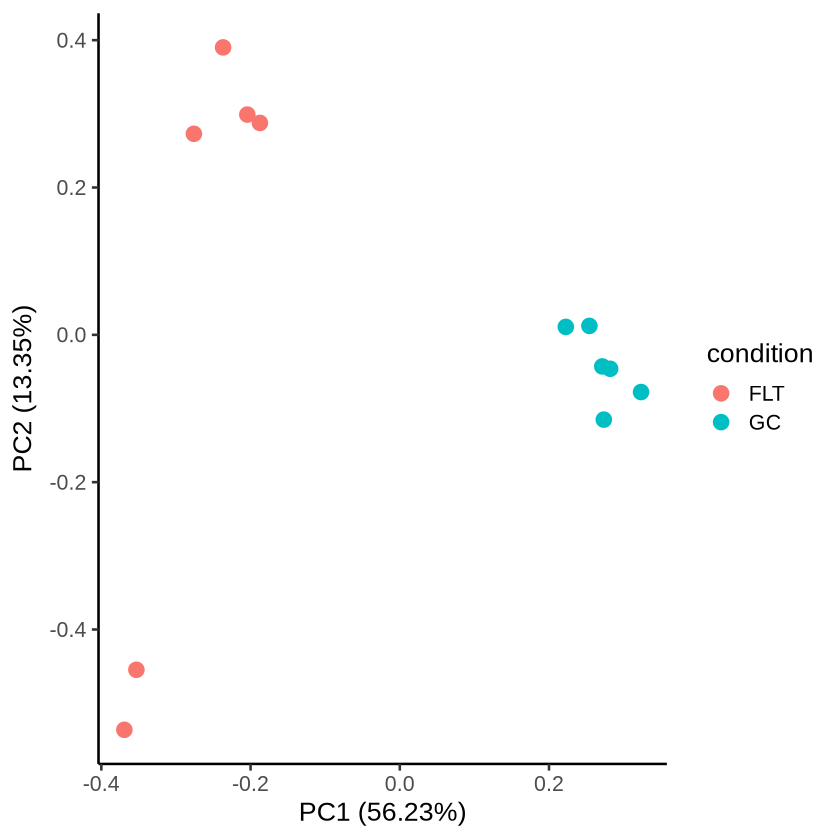

In [123]:
## Calculate the principal components of the normalized counts data ##
PCA_dge <- prcomp(t(exp_dge), scale = FALSE)

## Create PCA plot without samples labeled
autoplot(PCA_dge, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save PCA plot without samples labeled
ggsave(file.path(DGE_pca,'OSD-104_PCA_DGE_nolabels.png'), width = 8.5, height = 6, dpi = 300)

**Compare this PCA plot to the plot we made in [Step 2d](#2d.-DESeq2-Step-3:-Hypothesis-Testing-with-Wald-Test) using all normalized counts, and answer the following questions:**

1. How has the percent of variance explained by PC1 changed? What is responsible for this change?
   
2. Is there anything interesting to note about PC2?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The percent of variance explained by PC1 increased. 

We subset to only differentially expressed genes, so since PC1 is indicative of the differences between FLT and GC samples, when we only use genes that we know are significantly different between these groups, PC1 will now account for even more of the overall differences among samples.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The percent of variance explained by PC2 also increased, suggesting differences in significant DEGs among samples within the same group.

</details>
</div>

<br>

**Challenge**

Use the code block below to try creating more plots with autoplot, changing the parameters and see how the PCA plot changes.

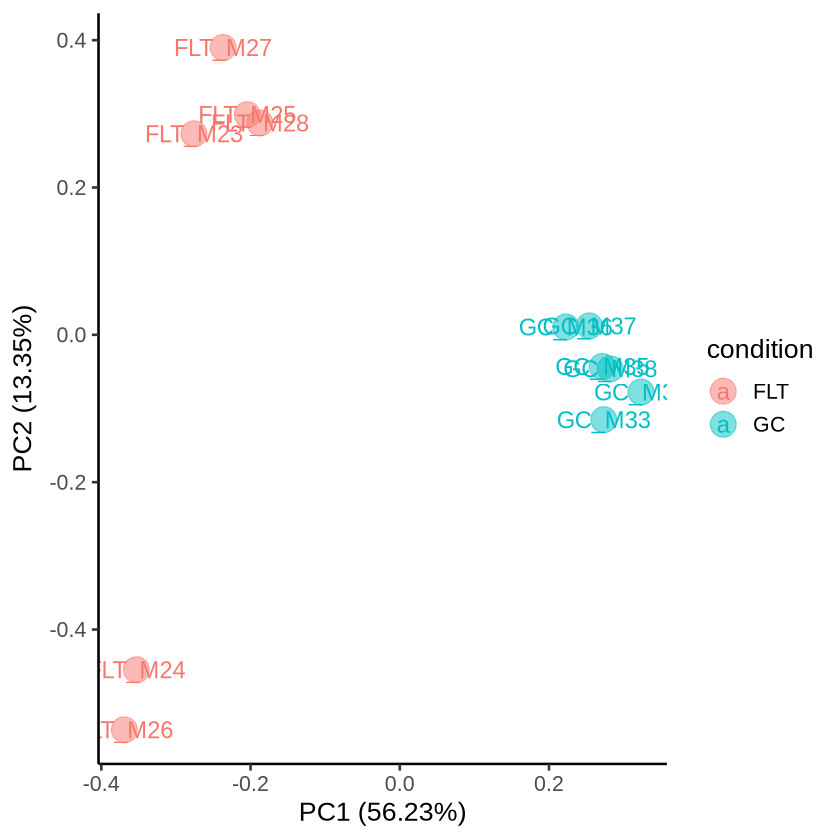

In [124]:
autoplot(PCA_dge, data=sampleTable, colour='condition', 
         label=TRUE, label.size=5, size=7, alpha=0.5) + theme_classic(base_size = 16)

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

**One way of doing this:**
> _Note: Adding lables to the samples will help determine which samples are in each of the 2 clusters we see for the flight group, which will allow us to start investigating what could be causing these differences._

```R
autoplot(PCA_dge, data=sampleTable, colour='condition', 
         label=TRUE, label.size=5, size=7, alpha=0.5) + theme_classic(base_size = 16) 
```


</details>
</div>

<br>

---

<a class="anchor" id="heatmap"></a>
## 4b. Heatmap

Heatmaps are commonly used to visualize gene expression data to see overall trends between samples in large lists of genes. Here, we will use a heatmap to examine the expression of our DEGs in the FLT and GC samples.

Before creating the heatmap, we'll first scale the counts data between 0 and 1. This makes it easier to visualize relative expression levels.

In [125]:
exp_dge_scale <- (exp_dge - min(exp_dge)) / (diff(range(exp_dge)))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `exp_dge_scale <- (exp_dge - min(exp_dge)) / (diff(range(exp_dge)))`:  
    - This command scales the expression data `exp_dge` to a range between 0 and 1 (also known as _min-max scaling_).
  
    - `(exp_dge - min(exp_dge))`:  
        - Subtracts the minimum value in `exp_dge` from each element, shifting the data so that the minimum value becomes 0.
  
    - `diff(range(exp_dge))`:  
        - Calculates the difference between the maximum and minimum values in `exp_dge`, which is the range of the data.
  
    - `/ (diff(range(exp_dge)))`:  
        - After subtracting the minimum value from each value in `exp_dge`, the data is divided by the range, normalizing the values so that they fall between 0 and 1.
  
    - `exp_dge_scale`:  
        - The result is assigned to `exp_dge_scale` variable, which contains the scaled gene expression data with values ranging from 0 to 1.

</div>

<br>

Now we're ready to create the heatmap:
> _**Note**_: Change the row title of the heatmap to match the number of differential expressed genes (DEGs) using the dimensions of the `exp_dge` data frame.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


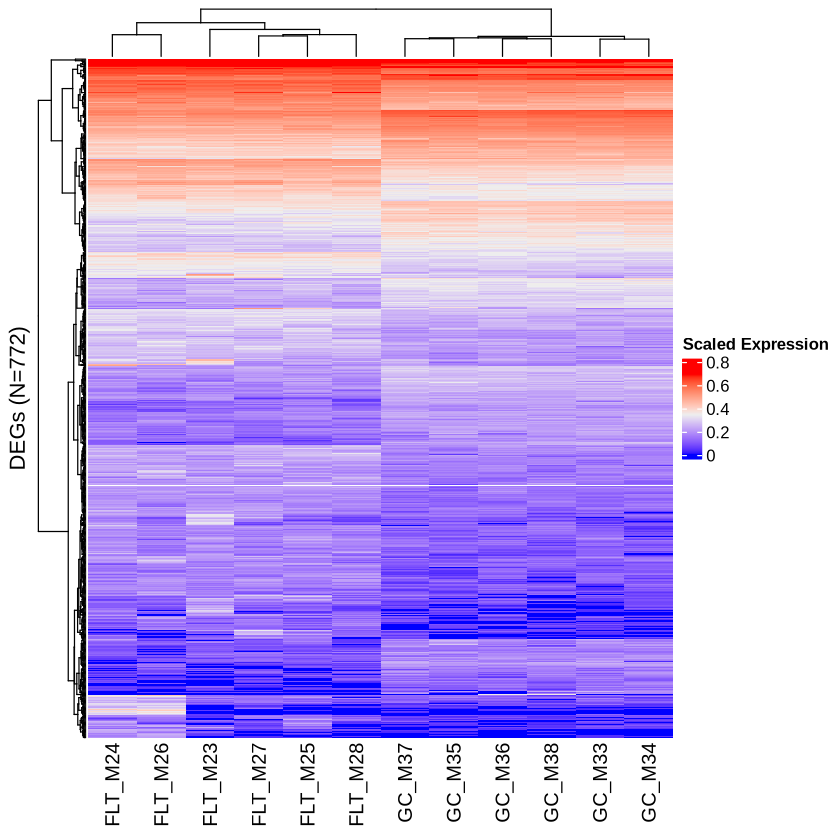

In [126]:
Heatmap(exp_dge_scale, show_row_names=FALSE, row_title="DEGs (N=772)", 
   heatmap_legend_param = list(title="Scaled Expression"))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `Heatmap(exp_dge_scale, show_row_names=FALSE, row_title="DEGs (N=772)", heatmap_legend_param = list(title="Scaled Expression"))`:  
    - Creates a heatmap visualization of the scaled gene expression data stored in `exp_dge_scale`.

    - `exp_dge_scale`:  
        - The input data for the heatmap, containing the scaled gene expression values for differentially expressed genes (DEGs).
  
    - `show_row_names=FALSE`:  
        - Suppresses the display of row names (gene names) to declutter the heatmap.
          > _Note: With so many DEGs, the row names would be difficult to see. However, if there were fewer DEGs, e.g. <100, then showing the row names could be useful._
  
    - `row_title="DEGs (N=772)"`:  
        - Sets the title for the rows of the heatmap, indicating that it represents _772 differentially expressed genes (DEGs)_.
  
    - `heatmap_legend_param = list(title="Scaled Expression")`:  
        - Customizes the heatmap legend by setting its title to "Scaled Expression", which clarifies that the heatmap represents the scaled expression values (ranging from 0 to 1).

</div>

<br>

Next, we'll generate the heatmap again, but this time, let's save it to a variable:

In [127]:
heatmap = Heatmap(exp_dge_scale, show_row_names=FALSE, row_title="DEGs (N=772)", 
   heatmap_legend_param = list(title="Scaled Expression"))

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


Now we can use the variable `heatmap` to save the image as a pdf with the function, `save_pdf()`:

In [128]:
save_pdf(heatmap, file.path(DGE_heatmaps,'OSD-104_heatmap_DGE.pdf'),
        width = 5, height = 5, units = c("in"))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `save_pdf(heatmap, file.path(DGE_heatmaps,'OSD-104_heatmap_DGE.pdf'), width = 5, height = 5, units = c("in"))`:  
    - Saves the heatmap to a PDF file, specifying the file path and dimensions.
  
    - `save_pdf()`:  
        - The function we're using to save our heatmap as a PDF file. It takes in parameters for the plot object (a heatmap in our case), the file path where the PDF should be saved, and the dimensions for the output.
  
    - `heatmap`:  
        - The heatmap object to be saved as a PDF. This is the heatmap we created with the `ComplexHeatmap` package above.
  
    - `file.path(DGE_heatmaps,'OSD-104_heatmap_DGE.pdf')`:  
        - Creates a valid file path to save the PDF.  
        - `DGE_heatmaps`: The variable containing the directory where the PDF will be saved.
        - `'OSD-104_heatmap_DGE.pdf'`: The filename for the saved PDF, indicating that this is the heatmap for the OSD-104 dataset.
  
    - `width = 5`:  
        - Specifies the width of the PDF. In this case, the width is set to 5 units (depending on the unit defined in the `units` parameter).
  
    - `height = 5`:  
        - Specifies the height of the PDF. The height is also set to 5 units.
  
    - `units = c("in")`:  
        - Defines the units for the dimensions. Here we use "in" for inches).

</div>

<br>

**Use the heatmap to answer the following questions:**

1. What overall trends do you notice in the expression of the DEGs in samples within the same group? What about samples in different groups?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b> Q1 Solution</b></summary>

<br>

The expression of the DEGs is more similar among samples within the same group than samples in different groups.

</details>
</div>

<br>


**Challenge:** Recall that before generating the heatmap, we first scaled the expression data. Use the following code block to see what the heatmap looks like if you don't scale the data. 
> Hint: Use the `Heatmap()` function again, but replace `exp_dge_scale` with `exp_dge`. 

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


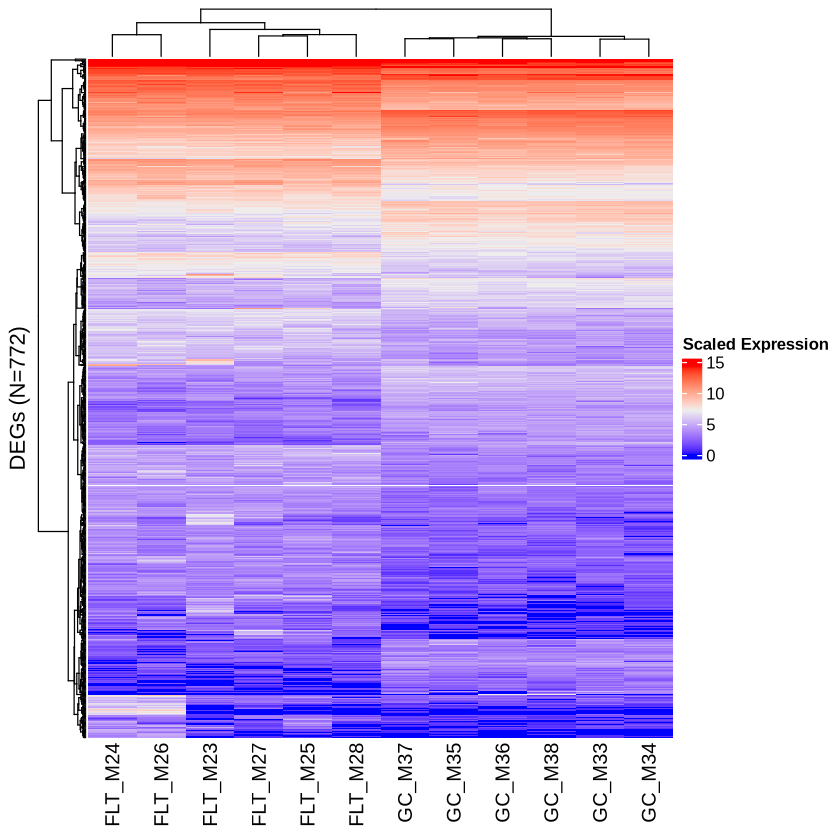

In [129]:
Heatmap(exp_dge, show_row_names=FALSE, row_title="DEGs (N=772)", 
   heatmap_legend_param = list(title="Scaled Expression"))

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

```R
Heatmap(exp_dge, show_row_names=FALSE, row_title="DEGs (N=772)", 
   heatmap_legend_param = list(title="Scaled Expression"))
```

</details>
</div>

<br>


What if we don't log transform the data, either? 
 
**Spoiler alert:** This crashes the kernel in the Jupyter Hub! Why do you think this is? 

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

If we don’t log transform the data, the expression values span from 1 to over 30,000.

If run Heatmap() on the non log transformed data, the function tries to fit all those values into the heatmap which is very computationally intensive and causes the kernel to crash.

</details>
</div>

<br>


We've generated this plot locally and provided it below. Is this a useful plot? 

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

No, it is very difficult to see differences between groups because all of the color differences are concentrated at the highest values.

</details>
</div>

<br>


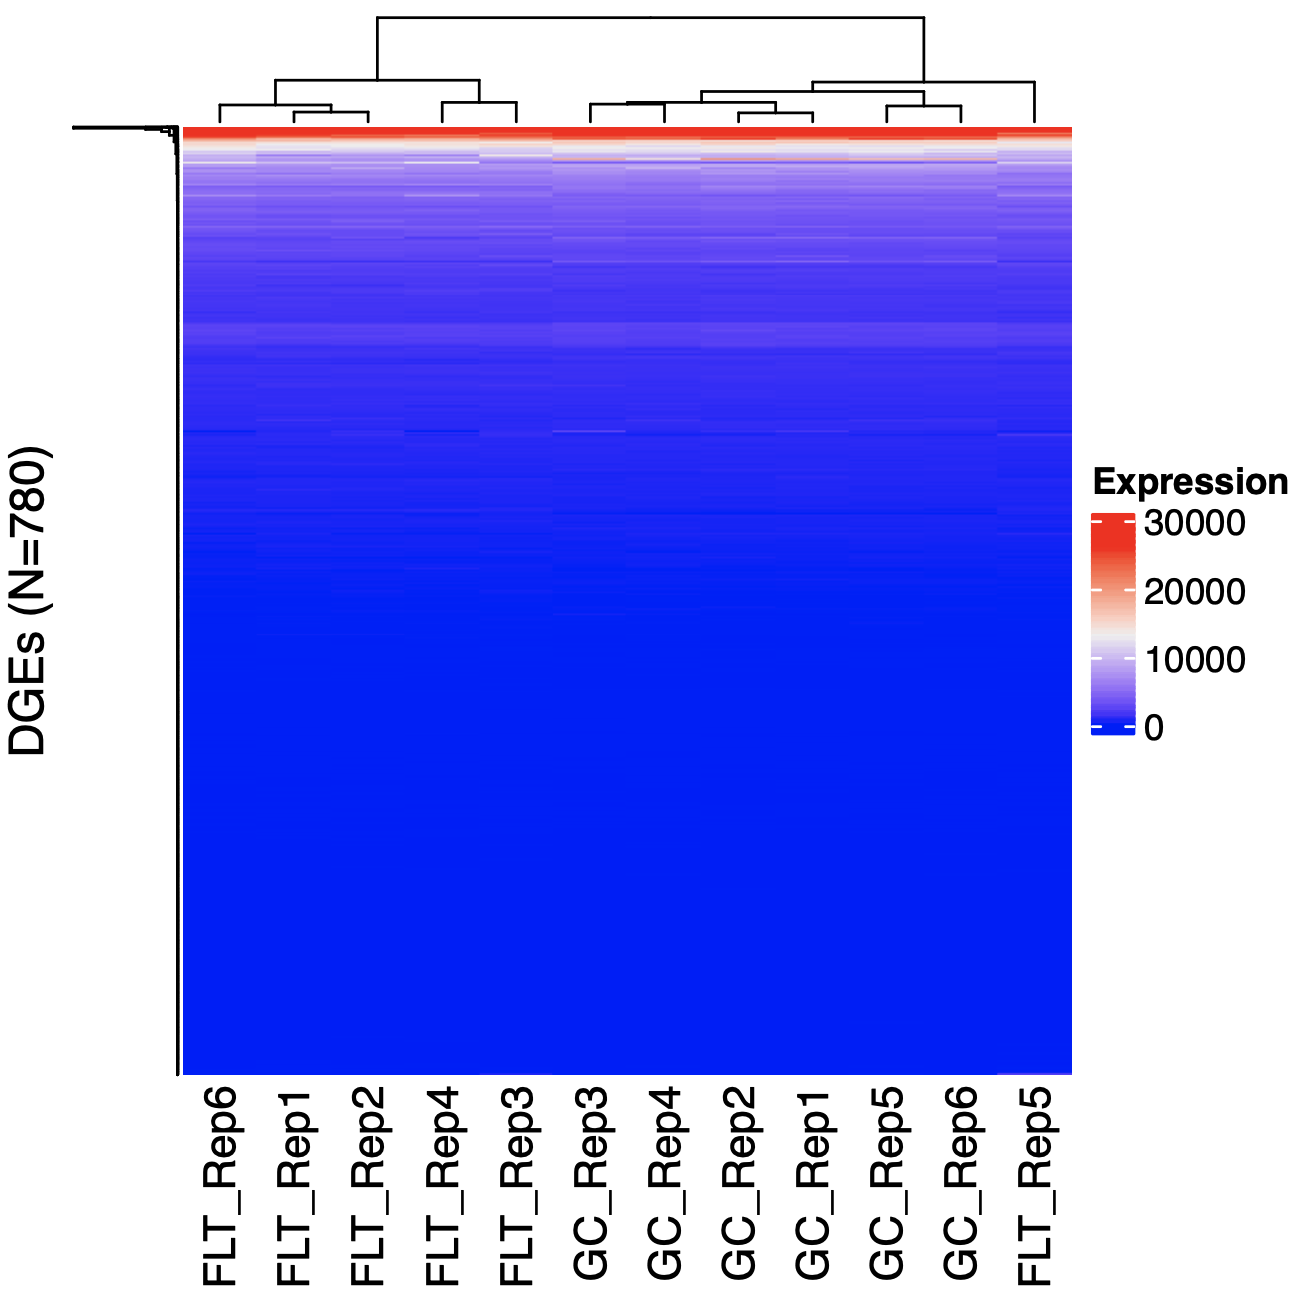

<br>

---


<a class="anchor" id="volcano"></a>
## 4c. Volcano Plot

Next, let's make a volcano plot to identify a few interesting genes. A volcano plot is a scatterplot which shows the relationship of the adjusted p-value to the log2 fold change. Genes with large fold changes that are also statistically significant by adjusted p-value are labeled.

First, we'll define the settings in the `EnhancedVolcano()` function to use the following cutoff values: log2 fold change cutoff > |1|, and an adjusted p-value cutoff of < 0.05. 

>_**Note**_: You can read more about the `EnhancedVolcano()` function and see some examples by clicking [here](https://bioconductor.org/packages/release/bioc/vignettes/EnhancedVolcano/inst/doc/EnhancedVolcano.html).

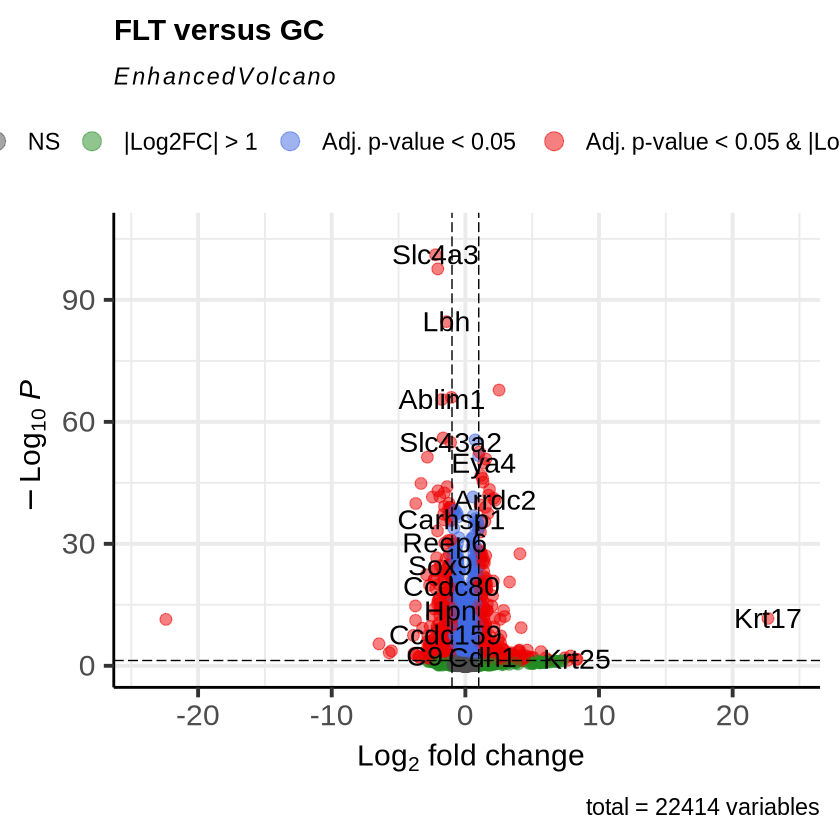

In [130]:
# Volcano plot showing genes differentially expressed in FLT vs GC
EnhancedVolcano(DGE_output_table,
    lab = DGE_output_table$SYMBOL,
    x = 'Log2fc_(FLT)v(GC)',
    y = 'Adj.p.value_(FLT)v(GC)',
    title = 'FLT versus GC',
    legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05',
      'Adj. p-value < 0.05 & |Log2FC| > 1'),
    pCutoff = 5e-2,
    FCcutoff = 1,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha=0.5)

## Save your volcano plot
ggsave(file.path(DGE_volcano,'OSD-104_volcano_DGE.png'), width = 6.5, height = 8.5, dpi = 300)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `EnhancedVolcano()`:  
    - The function used to create a _volcano plot_ to visualize differentially expressed genes from data in a dataframe (`DGE_output_table`), by plotting log fold change against adjusted p-value.
  
    - `DGE_output_table`:  
        - The data frame containing the differential gene expression results, which includes log fold change, adjusted p-values, and gene symbols.

    - `lab = DGE_output_table$SYMBOL`:  
        - Labels the points (genes) in the volcano plot using the gene symbols stored in the `SYMBOL` column of `DGE_output_table`.

    - `x = 'Log2fc_(FLT)v(GC)'`:  
        - Defines the x-axis values for the volcano plot, representing the log2 fold change between _FLT_ and _GC_ conditions.

    - `y = 'Adj.p.value_(FLT)v(GC)'`:  
        - Defines the y-axis values for the plot, representing the adjusted p-value for the comparison between FLT and GC conditions.

    - `title = 'FLT versus GC'`:  
        - Sets the title of the volcano plot to "FLT versus GC".

    - `legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05', 'Adj. p-value < 0.05 & |Log2FC| > 1')`:  
        - Customizes the labels in the plot legend to represent different categories of significance:  
            - `NS`: Not significant,  
            - `|Log2FC| > 1`: Genes with a log2 fold change greater than 1 or less than -1,  
            - `Adj. p-value < 0.05`: Genes with a significant adjusted p-value, < 0.05,  
            - `Adj. p-value < 0.05 & |Log2FC| > 1`: Genes that meet both significance and fold change criteria.

    - `pCutoff = 5e-2`:  
        - Sets the cutoff for the adjusted p-value to 0.05 (5e-2) to define statistical significance.

    - `FCcutoff = 1`:  
        - Sets the fold change cutoff to 1, so genes with a log2 fold change greater than 1 or less than -1 are considered biologically meaningful.

    - `pointSize = 3.0`:  
        - Specifies the size of the points (genes) in the plot.

    - `labSize = 6.0`:  
        - Sets the size of the gene labels in the plot.

    - `colAlpha=0.5`:  
        - Adjusts the transparency of the points (genes) in the plot.

<br>

- `ggsave()`:  
    - Function used to save the volcano plot as a _PNG_ file in the `DGE_volcano` directory.

    - `file.path(DGE_volcano,'OSD-104_volcano_DGE.png')`:  
        - Creates the file path for saving the volcano plot. In this case, the file will be saved in the `DGE_volcano` directory and named `OSD-104_volcano_DGE.png`.

    - `width = 6.5, height = 8.5`:  
        - Specifies the dimensions of the saved PNG file (6.5 inches wide and 8.5 inches high).

    - `dpi = 300`:  
        - Sets the resolution of the saved PNG file to 300 dpi, which is suitable for publication-quality images.

</div>

<br>

**Use the volcano plot (and our collective conscious - aka the internet) to answer the following questions:**

1. Which gene has the smallest adjusted p-value that still passes our Log2FC cutoff?
   
2. Is *Slc4a3* more highly expressed in FLT or GC samples? How do you know?

3. Which gene is most highly differentially expressed in the FLT group? Does this gene also pass the adjusted p-value cutoff?

4. Since *Slc4a3* is the most significant differentially expressed gene, see if you can find its biological function (feel free to use a search engine, e.g. Google, to help you out). Are you able to find an annotated function?

5. What is the function of the gene *Krt17* ? Is it more highly expressed in the FLT or GC condition? Based on its function, why do you think this is?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

*Slc4a3* is the gene with the smallest adjusted p-value that still passes our Log2FC cutoff.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

*Slc4a3* is more highly expressed in GC samples because it has a negative LFC and we plotted the FLT vs GC comparison.

</details>
</div>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

*Krt17* is the most highly differentially expressed gene in the FLT group. 

Yes, it does pass the adjusted p-value cutoff.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

*Slc4a3* encodes for a plasma membrane anion exchange protein, solute carrier family 4 membrane 3. 

Annotated function of *Slc4a3* from the UniProt summary in [GeneCards](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SLC4A3):  

Sodium-independent anion exchanger which mediates the electroneutral exchange of chloride for bicarbonate ions across the cell membrane (PubMed:[29167417](https://pubmed.ncbi.nlm.nih.gov/29167417/), [7923606](https://pubmed.ncbi.nlm.nih.gov/7923606/)). May be involved in the regulation of intracellular pH, and the modulation of cardiac action potential (PubMed:[29167417](https://pubmed.ncbi.nlm.nih.gov/29167417/)). ([B3A3_HUMAN,P48751](https://www.uniprot.org/uniprotkb/P48751/entry#function))


</details>
</div>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q5 Solution</b></summary>

<br>

*Krt17* encodes for a keratin protein. 

*Krt17* is more highly expressed in the FLT condition. 

Since keratin is involved in forming intermediate filaments, which respond to physical stress, it makes sense that *Krt17* is more highly expressed in the FLT group. Additionally, at least one scientific publication, [https://bmcgenomics.biomedcentral.com/track/pdf/10.1186/1471-2164-15-303.pdf](https://bmcgenomics.biomedcentral.com/track/pdf/10.1186/1471-2164-15-303.pdf), shows that *Krt17* is up-regulated in hypoxic conditions (i.e. low oxygen) and we know that the International Space Station has less oxygen than we have here on Earth, creating a slightly hypoxic condition for the FLT samples.

</details>
</div>

<br>

**Challenge:** Use the code blocks below to create another volcano plot (or two) with different adjusted p-value and log2FC cutoffs and see how the plot changes. 
> _**Hint**_: Start with the `EnhancedVolcano()` command above then change the values corresponding to the adjusted p-value and log2FC cutoffs. If you're unsure what those are, take a look at the `EnhancedVolcano()` documentation [here](https://bioconductor.org/packages/release/bioc/vignettes/EnhancedVolcano/inst/doc/EnhancedVolcano.html).

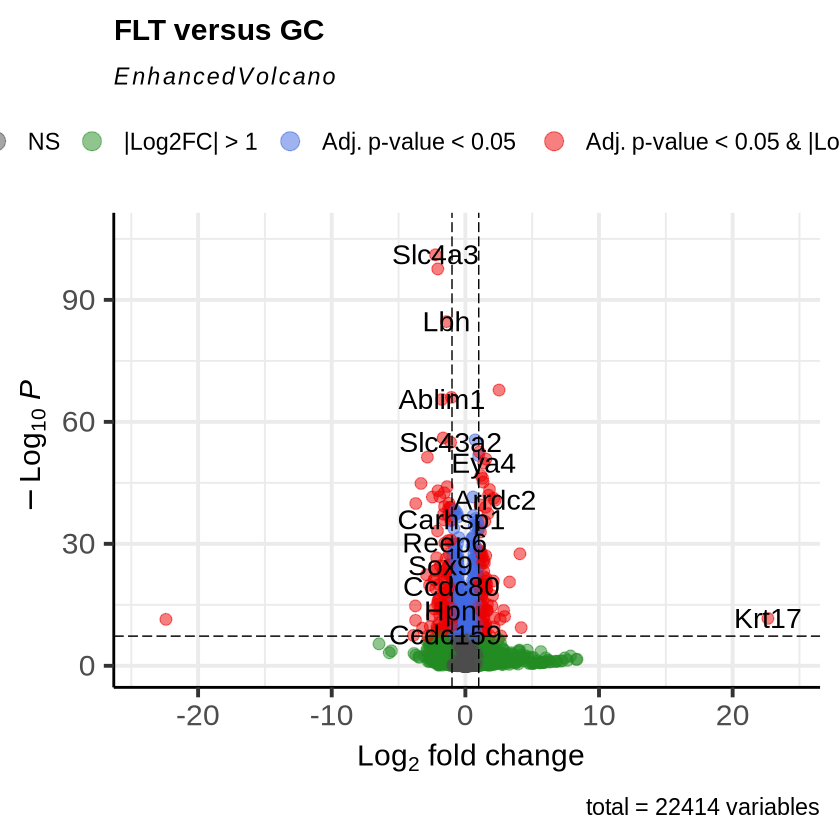

In [131]:
EnhancedVolcano(DGE_output_table,
    lab = DGE_output_table$SYMBOL,
    x = 'Log2fc_(FLT)v(GC)',
    y = 'Adj.p.value_(FLT)v(GC)',
    title = 'FLT versus GC',
    legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05',
      'Adj. p-value < 0.05 & |Log2FC| > 1'),
    pCutoff = 5e-8,
    FCcutoff = 1,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha=0.5)  

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

One example with the adjusted p-value cutoff more stringient:

```R
EnhancedVolcano(DGE_output_table,
    lab = DGE_output_table$SYMBOL,
    x = 'Log2fc_(FLT)v(GC)',
    y = 'Adj.p.value_(FLT)v(GC)',
    title = 'FLT versus GC',
    legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05',
      'Adj. p-value < 0.05 & |Log2FC| > 1'),
    pCutoff = 5e-8,
    FCcutoff = 1,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha=0.5)  
```

</details>
</div>

<br>

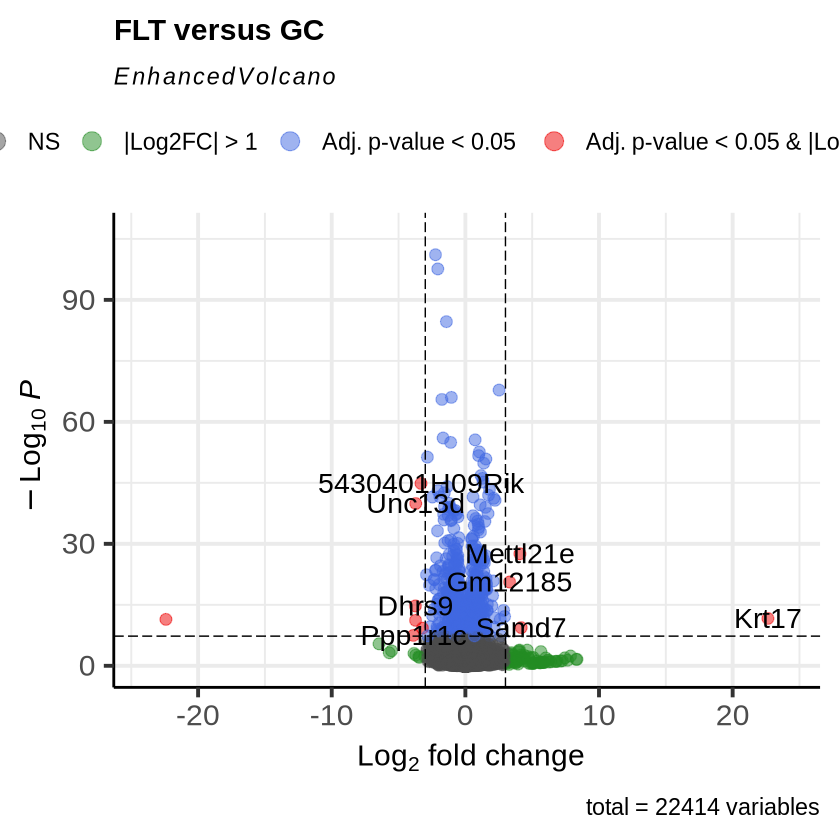

In [132]:
EnhancedVolcano(DGE_output_table,
    lab = DGE_output_table$SYMBOL,
    x = 'Log2fc_(FLT)v(GC)',
    y = 'Adj.p.value_(FLT)v(GC)',
    title = 'FLT versus GC',
    legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05',
      'Adj. p-value < 0.05 & |Log2FC| > 1'),
    pCutoff = 5e-8,
    FCcutoff = 3,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha=0.5)

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

Another example with the adjusted p-value and the log2 fold change cutoffs more stringient:

```R
EnhancedVolcano(DGE_output_table,
    lab = DGE_output_table$SYMBOL,
    x = 'Log2fc_(FLT)v(GC)',
    y = 'Adj.p.value_(FLT)v(GC)',
    title = 'FLT versus GC',
    legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05',
      'Adj. p-value < 0.05 & |Log2FC| > 1'),
    pCutoff = 5e-8,
    FCcutoff = 3,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha=0.5)  
```

</details>
</div>

<br>

---

<a class="anchor" id="gsea"></a>
## 4d. Gene Set Enrichment Analysis (GSEA)

Finally, let's perform Gene Set Enrichment Analysis ([GSEA](https://www.gsea-msigdb.org/gsea/index.jsp)). GSEA is a computational method used to determine whether predefined sets of genes (such as pathways or functional groups) show statistically significant differences in expression between different experimental conditions (e.g. spaceflight and ground control). 

<br>

#### Set DGE Filtering Parameters

We'll start by specify the filtering parameters to use to prepare our DGE output table for subsequent GSEA:

- **mean_exp_cutoff**: Cut off value for the average gene expression across all samples. Genes below this value will be removed. 
- **rank_var**: The DESeq2 results statistic you want to use to rank your features (genes), options include:
  - `Log2fc`: Log(2) fold change
  - `Stat`: Wald statistic 
  - `P.value`: p-value 
  - `Adj.p.value`: p-value adjusted for multiple comparisons testing
- **keytype**: The gene IDs used in your DGE analysis above, options include:
  - `ENSEMBL`: For animals
  - `TAIR`: For plants

In [133]:
mean_exp_cutoff <- 50
rank_var <- "Stat"
keytype <- "ENSEMBL" ## Change ENSEMBL to TAIR for plant studies ##

<br>

#### Filter DGE Results On Contrast of Interest

In [134]:
## Pull DESeq2 results columns from the DGE table ##
IDs <- DGE_output_table %>% dplyr::select( !!rlang::sym(keytype))
all_mean <- DGE_output_table %>% dplyr::select(All.mean)
log2fc <- DGE_output_table %>% dplyr::select( !!rlang::sym("Log2fc_(FLT)v(GC)"))
stat <- DGE_output_table %>% dplyr::select( !!rlang::sym("Stat_(FLT)v(GC)"))
pvalue <- DGE_output_table %>% dplyr::select( !!rlang::sym("P.value_(FLT)v(GC)"))
padj <- DGE_output_table %>% dplyr::select( !!rlang::sym("Adj.p.value_(FLT)v(GC)"))

## Combine all DESeq2 results columns from the DGE table ##
DGE_res <- cbind(IDs, all_mean, log2fc, stat, pvalue, padj)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `IDs <- DGE_output_table %>% dplyr::select( !!rlang::sym(keytype))`:  
    - Selects the column from `DGE_output_table` that matches the `keytype` variable.  
    - `!!rlang::sym(keytype)`: Uses `rlang::sym` to pull the info stored in the `keytype` variable and the `!!` operator to remove the quotes so it can be evaluated within the `dplyr::select()` function.

- `all_mean <- DGE_output_table %>% dplyr::select(All.mean)`:  
    - Selects the `All.mean` column from `DGE_output_table`, which contains the mean expression value for each gene across all samples.

- `log2fc <- DGE_output_table %>% dplyr::select( !!rlang::sym("Log2fc_(FLT)v(GC)") )`:  
    - Selects the column containing the log2 fold change values for the comparison between _FLT_ and _GC_ conditions.  
    - `!!rlang::sym("Log2fc_(FLT)v(GC)")`: Dynamically references the column name even though it contains special characters (parentheses). This ensures the column is correctly interpreted by `dplyr::select()`.

- `stat <- DGE_output_table %>% dplyr::select( !!rlang::sym("Stat_(FLT)v(GC)") )`:  
    - Selects the column that holds the statistical test values (e.g., Wald statistic) for the _FLT_ vs _GC_ comparison.

- `pvalue <- DGE_output_table %>% dplyr::select( !!rlang::sym("P.value_(FLT)v(GC)") )`:  
    - Selects the column that contains the raw p-values for the _FLT_ vs _GC_ comparison.

- `padj <- DGE_output_table %>% dplyr::select( !!rlang::sym("Adj.p.value_(FLT)v(GC)") )`:  
    - Selects the column with the adjusted p-values (corrected for multiple testing) for the _FLT_ vs _GC_ comparison.

<br>

- `DGE_res <- cbind(IDs, all_mean, log2fc, stat, pvalue, padj)`:  
    - Combines all the selected columns (IDs, All.mean, Log2FC, Stat, P.value, and Adj.p.value) into a new data frame `DGE_res` using `cbind()`.  
    - This new table contains relevant information for each gene, including identifiers, mean expression, log2 fold changes, statistical values, and p-values.

</div>

<br>

Remove low expressing genes from your `DGE_res` table:

In [135]:
DGE_res <- DGE_res %>% dplyr::filter(All.mean > mean_exp_cutoff)

Look at the dimensions of your `DGE_res` table:

In [138]:
dim(DGE_res)

[1] 12586     6

**Use the dimensions of your `DGE_res` table after filtering low expressing genes to answer the following question:**

1. How many genes were removed?

  > *Hint: Subtract this value from the number of features in the `DEG_output_table`*

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

22,414 - 12,586 = 9,828 genes were removed after filtering.

</details>
</div>

<br>

Take a look at your `DGE_res` table:

In [139]:
head(DGE_res)

,ENSEMBL,All.mean,Log2fc_(FLT)v(GC),Stat_(FLT)v(GC),P.value_(FLT)v(GC),Adj.p.value_(FLT)v(GC)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000000001,901.1347,-0.05347980,-0.7980902,4.248182e-01,6.219642e-01
2,ENSMUSG00000000028,124.3017,0.07490631,0.4857526,6.271426e-01,7.828666e-01
3,ENSMUSG00000000031,94907.3692,-0.56801131,-6.7356304,1.632207e-11,5.266460e-10
4,ENSMUSG00000000056,4903.5072,-0.21757558,-5.6560759,1.548730e-08,3.080695e-07
5,ENSMUSG00000000058,853.5538,0.03720972,0.3312391,7.404639e-01,8.576811e-01
6,ENSMUSG00000000078,2626.8111,-0.22262308,-1.9407344,5.229050e-02,1.466490e-01


<br>

#### Rank DGE Results

GSEA requires the input gene list to be ranked in order to evaluate whether genes in the predefined set are primarily located at the top (upregulated) or bottom (downregulated) of the ranked list, thus revealing biologically meaningful trends that may not be apparent from single-gene analyses.

Any of the DESeq2 results columns can be used to rank our gene list. Here we use the Wald statistic, defined in the `rank_var` variable above, to rank our genes, which is commonly used for GSEA.

Rank the features (genes) in our `DGE_res` dataframe using our `rank_var` specified above:

In [140]:
DGE_res_ranked <- DGE_res %>% dplyr::arrange(desc( !!rlang::sym(paste0(rank_var,"_(FLT)v(GC)"))))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `DGE_res_ranked <- DGE_res %>% dplyr::arrange(desc( !!rlang::sym(paste0(rank_var,"_(FLT)v(GC)"))))`:  
    - This command ranks (or arranges) the rows of the `DGE_res` data frame based on a specific column, with the order set to _descending_.

    - `DGE_res`:  
        - The data frame holding the DESeq2 results (previously created) which contains the data columns we selected above.

    - `%>%`:  
        - The _pipe operator_ allows for chaining functions together, making the code cleaner and easier to read. It passes `DGE_res` into the next function (`dplyr::arrange`).

    - `dplyr::arrange()`:  
        - A function from the `dplyr` package that _rearranges_ the rows of a data frame based on one or more columns. The default sorting order is ascending unless `desc()` is used.

    - `desc()`:  
        - This ensures that the sorting is done in _descending order_ (from largest to smallest values).

    - `!!rlang::sym(paste0(rank_var,"_(FLT)v(GC)"))`:  
        - Dynamically constructs and evaluates the column name used for ranking.  
        - `paste0(rank_var, "_(FLT)v(GC)")`: Concatenates the value stored in the `rank_var` variable with the string `"_(FLT)v(GC)"` to create the full column name. 
        - `!!rlang::sym()`: Converts the concatenated string into a symbol (a reference to a column) and evaluates it, ensuring `arrange()` can use it as the sorting criterion.

</div>

<br>

View your `DGE_res_ranked` table to make sure the data are now ranked in descending order based on your `rank_var` column:

In [141]:
head(DGE_res_ranked)

,ENSEMBL,All.mean,Log2fc_(FLT)v(GC),Stat_(FLT)v(GC),P.value_(FLT)v(GC),Adj.p.value_(FLT)v(GC)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000028444,599.2561,2.5223782,17.97344,3.146161e-72,1.517629e-68
2,ENSMUSG00000030554,36028.7042,0.7295747,16.29269,1.112198e-59,2.682482e-56
3,ENSMUSG00000068697,20679.6890,1.0451515,15.85516,1.294880e-56,2.498471e-53
4,ENSMUSG00000020919,12316.8980,0.9921166,15.71804,1.137859e-55,1.995907e-52
5,ENSMUSG00000026173,665.5547,1.5318120,15.58465,9.257004e-55,1.373953e-51
6,ENSMUSG00000010461,933.7451,1.3723095,15.42991,1.030105e-53,1.419706e-50


Next, we'll extract our sorted `rank_var` column to create our gene list that we will use to perform GSEA:

In [142]:
gene_list <- DGE_res_ranked %>% dplyr::select( !!rlang::sym(paste0(rank_var,"_(FLT)v(GC)"))) %>% pull

## Add IDs from the DGE_res_ranked dataframe to the gene_list ##
names(gene_list) <- DGE_res_ranked %>% dplyr::select( !!rlang::sym(keytype)) %>% pull

## View your ranked gene_list ##
head(gene_list)

ENSMUSG00000028444 ENSMUSG00000030554 ENSMUSG00000068697 ENSMUSG00000020919 ENSMUSG00000026173 ENSMUSG00000010461 
          17.97344           16.29269           15.85516           15.71804           15.58465           15.42991

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `gene_list <- DGE_res_ranked %>% dplyr::select( !!rlang::sym(paste0(rank_var,"_(FLT)v(GC)"))) %>% pull`:  
    - Creates `gene_list`, a vector that contains the values from a dynamically specified column in the `DGE_res_ranked` data frame.
  
    - `dplyr::select( !!rlang::sym(paste0(rank_var,"_(FLT)v(GC)")))`:  
        - Dynamically constructs the column name by concatenating `rank_var` and `"_(FLT)v(GC)"` to select the column used for ranking.  
        - `!!rlang::sym()`: Converts the constructed string into a symbol to select the column in `dplyr::select()`.
  
    - `pull`:  
        - Extracts the selected column as a vector from the data frame.

- `names(gene_list) <- DGE_res_ranked %>% dplyr::select( !!rlang::sym(keytype)) %>% pull`:  
    - Assigns names to the elements of `gene_list` using IDs from the `DGE_res_ranked` data frame.

    - `dplyr::select( !!rlang::sym(keytype))`:  
        - Dynamically selects the column specified by the `keytype` variable from the `DGE_res_ranked` data frame, which contains the ENSEMBL IDs.

    - `pull`:  
        - Extracts this column as a vector to be used as the names for `gene_list`.

</div>

<br>

#### Set GSEA Parameters

To perform GSEA, we'll set parameters to specify how we want the analysis performed. Here is a description of the parameters we'll be specifying in the code block below:

- **ont**: The sub-ontology to use, options include:
  - `BP`: Biological Processes
    > Focuses on the pathways and larger biological processes in which a gene product is involved. Examples include processes like cell division, immune response, or signal transduction. 
  - `MF`: Molecular Function
    > Describes the biochemical activities of gene products at the molecular level. Examples include functions like enzyme activity, binding affinity, or transport activity. 
  - `CC`: Cellular Component
    > Refers to where gene products are located within a cell or their subcellular structures. Examples include mitochondria, nucleus, cell membrane, or protein complexes. 
  - `ALL`: Use all three sub-ontologies
- **minGSSize**: Minimum size of a gene set for testing. Gene sets containing a total number of genes below this threshold will be excluded.
- **maxGSSize**: Maximum size of a gene set for testing. Gene sets containing a total number of genes above this threshold will be excluded.
- **pvalueCutoff**: The adjusted p-value cutoff on enrichment tests to report.
- **pAdjustMethod**: Method to use to correct for multiple comparisons testing, options include:
> You can learn more about each of the methods listed below in [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5506159/).
  - `holm`: Holm adjustment
  - `hochberg`: Hochberg adjustment
  - `hommel`: Hommel adjustment
  - `bonferroni`: Bonferroni adjustment
  - `BH`: Benjamini-Hochberg adjustment
  - `BY`: Benjamini and Yekutieli adjustment
  - `fdr`: false discovery rate
  - `none`: Do not correct for multiple comparisons testing

In [143]:
ont <- "BP"
minGSSize <- 10
maxGSSize <- 500
pvalueCutoff <- 0.05
pAdjustMethod <- "BH"

<br>

#### Run GSEA Using Gene Ontology (GO)

In this section we will use geneset enrichment analyses provided in the [clusterProfiler](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html) package on [Bioconductor](http://www.bioconductor.org/). There are a variety of different tools in `clusterProfiler` that allow you to run GSEA using several different types of gene sets. Here we use the genesets associated with the [gene ontologies (GO)](http://geneontology.org/) of our species of interest. You are welcome (and encouraged) to check out the [clusterProfiler](https://bioconductor.org/packages/release/bioc/manuals/clusterProfiler/man/clusterProfiler.pdf) documentation and set up additional code blocks to run GSEA using different types of gene sets.

In [144]:
gse <- gseGO(geneList = gene_list,
             ont = ont,
             keyType = keytype,
             minGSSize = minGSSize,
             maxGSSize = maxGSSize,
             pvalueCutoff = pvalueCutoff,
             pAdjustMethod = pAdjustMethod,
             OrgDb = ann.dbi,
             by = "fgsea")

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.08% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `gse <- gseGO(geneList = gene_list, ont = ont, keyType = keytype, minGSSize = minGSSize, maxGSSize = maxGSSize, pvalueCutoff = pvalueCutoff, pAdjustMethod = pAdjustMethod, OrgDb = ann.dbi, by = "fgsea")`:  
    - This command performs _Gene Set Enrichment Analysis (GSEA)_ using the _Gene Ontology (GO)_ framework, analyzing the ranked `gene_list` to identify enriched gene sets in a specific ontology (e.g., Biological Process, Molecular Function, or Cellular Component).

    - `gseGO()`:  
        - A function from the `clusterProfiler` R package that performs GSEA specifically for Gene Ontology. It evaluates whether any GO terms are significantly enriched at the top or bottom of the ranked gene list.

    - `geneList = gene_list`:  
        - The ranked list of genes we generated above that GSEA will analyze for enrichment.

    - `ont`, `keyType`, `minGSSize`, `maxGSSize`, `pvalueCutoff`, `pAdjustMethod`:  
        - Specifies the parameters described [above](#Set-GSEA-Parameters).

    - `OrgDb = ann.dbi`:  
        - The organism-specific annotation database used to map gene identifiers to GO terms. Recall that `ann.dbi` is the variable we set in [step 3b](#3b.-Add-Gene-Annotations) above that specifies the `org.Mm.eg.db` database.

    - `by = "fgsea"`:  
        - Specifies the algorithm used for GSEA. Here, `"fgsea"` refers to _fast GSEA_, a more efficient algorithm for computing GSEA results, especially useful for large gene sets.

</div>

<br>

Next we will convert the results of our GSEA to a dataframe and save it as a CSV file, then view our GSEA output table:

<div class="alert alert-block alert-info">
<b>GSEA output table content</b><br>

The GSEA output table contains the following columns:

- **ID**: Gene set IDs, here we are using Gene Ontologies (GO).
- **Description**: Indicates the name of the sub-ontology set, the sub-ontology set type defined as the `ont` variable specified above.
- **setSize**: The number of genes in the gene set, after filtering out genes that are not present in the input expression dataset.
- **enrichmentScore**: Unnormalized enrichment score (ES), determined based on how much a gene set is overrepresented at the top or bottom of a ranked list of genes. A positive ES indicates gene set enrichment at the top of the ranked list whereas a negative ES indicates gene set enrichment at the bottom of a ranked list.
- **NES**: Normalized enrichment score, the ES after correcting for differences in ES between gene sets due to differences in the size of the gene sets evaluated.
- **pvalue**: An enrichment p-value representing the statistical significance of the ES, which does not take into account differences in gene set size and has not been adjusted for multiple hypothesis testing. (This is not a useful metric to determine significance.)
- **p.adjust**: A p-value adjusted for multiple testing using the correction method specified with the `pAdjustMethod` variable above.
- **qvalue**: A measure of the false discovery rate (FDR), which is the estimated probability that a gene set with a given NES represents a false positive finding. The closer the qvalue is to zero, the greater the perturbation of the gene set.
  > _Note: Although q-values are always positive (between 0 and 1), the gsea augments the value with either a positive or negative sign to indicate up-regulation or down-regulation, respectively, of a gene set._
- **rank**: The position in the ranked list at which the maximum enrichment score occurred. Genesets that achieve the maximum enrichment score towards the top or bottom of the ranked list provided are the most interesting.
- **leading_edge**: 3 statistics that define the leading edge subset of a gene set, which is the subset of members of the gene set that contribute the most to the ES.
   - **tags**: The % of gene hits before (for positive ES) or after (for negative ES) the peak in the running enrichment score, which indicates the % of genes in the gene set contributing to the ES.
   - **list**: The % of genes in the ranked gene list before (for positive ES) or after (for negative ES) the peak in the running enrichment score, which indicates where in the list the ES is attained.
   - **signal**: The enrichment signal strength that contributes to the 2 statistics described above. A maximal signal strength (100%) occurs if all genes in the gene set are within the very top (or bottom) of the ranked list of genes, and a minimal signal strength (0%) occurs if the genes in the gene set are spread throughout the ranked gene list. 
- **core_enrichment**: Genes that contribute to the leading edge subset of the gene set, these genes contribute most to the enrichment result.


<br>

**To learn more about how to interpret GSEA results check out the "Interpreting GSEA Results" section of the [GSEA User Guide](http://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html).**

</div>

<br>

In [145]:
gse_table <- as.data.frame(gse)

## Save the GSEA output table to a file ##
write.csv(gse_table,file.path(DGE_gsea, paste("OSD-104_FLT_v_GC_GSEA", rank_var, "ranked_output.csv", sep="_")))

head(gse_table)

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0006457,GO:0006457,protein folding,161,-0.5120951,-2.158420,8.862818e-10,2.419106e-06,2.147601e-06,2876,"tags=47%, list=23%, signal=37%",ENSMUSG00000019471/ENSMUSG00000025289/ENSMUSG00000026035/ENSMUSG00000032115/ENSMUSG00000026812/ENSMUSG00000071072/ENSMUSG00000026849/ENSMUSG00000034024/ENSMUSG00000004937/ENSMUSG00000073676/ENSMUSG00000109865/ENSMUSG00000022136/ENSMUSG00000029198/ENSMUSG00000033684/ENSMUSG00000054836/ENSMUSG00000025823/ENSMUSG00000006412/ENSMUSG00000003226/ENSMUSG00000002064/ENSMUSG00000028851/ENSMUSG00000027006/ENSMUSG00000020328/ENSMUSG00000091971/ENSMUSG00000024359/ENSMUSG00000028960/ENSMUSG00000027274/ENSMUSG00000038503/ENSMUSG00000042043/ENSMUSG00000057069/ENSMUSG00000053838/ENSMUSG00000001416/ENSMUSG00000024847/ENSMUSG00000005483/ENSMUSG00000078622/ENSMUSG00000014195/ENSMUSG00000090877/ENSMUSG00000007033/ENSMUSG00000007739/ENSMUSG00000020260/ENSMUSG00000032285/ENSMUSG00000022769/ENSMUSG00000021715/ENSMUSG00000059355/ENSMUSG00000036327/ENSMUSG00000025613/ENSMUSG00000032932/ENSMUSG00000003814/ENSMUSG00000026203/ENSMUSG00000001555/ENSMUSG00000024944/ENSMUSG00000020361/ENSMUSG00000006095/ENSMUSG00000027248/ENSMUSG00000075467/ENSMUSG00000004460/ENSMUSG00000037287/ENSMUSG00000039230/ENSMUSG00000025130/ENSMUSG00000020048/ENSMUSG00000028035/ENSMUSG00000021270/ENSMUSG00000034203/ENSMUSG00000029657/ENSMUSG00000029781/ENSMUSG00000038086/ENSMUSG00000036854/ENSMUSG00000029014/ENSMUSG00000015656/ENSMUSG00000022403/ENSMUSG00000024580/ENSMUSG00000028416/ENSMUSG00000023944/ENSMUSG00000032060/ENSMUSG00000020368/ENSMUSG00000026864/ENSMUSG00000028974
GO:0042254,GO:0042254,ribosome biogenesis,304,-0.4313464,-1.952155,6.014017e-10,2.419106e-06,2.147601e-06,3748,"tags=47%, list=30%, signal=34%",ENSMUSG00000004100/ENSMUSG00000013663/ENSMUSG00000040025/ENSMUSG00000022247/ENSMUSG00000025962/ENSMUSG00000030423/ENSMUSG00000024608/ENSMUSG00000027133/ENSMUSG00000024570/ENSMUSG00000063316/ENSMUSG00000033285/ENSMUSG00000017999/ENSMUSG00000025785/ENSMUSG00000042729/ENSMUSG00000020526/ENSMUSG00000027787/ENSMUSG00000026083/ENSMUSG00000000787/ENSMUSG00000003429/ENSMUSG00000035047/ENSMUSG00000060938/ENSMUSG00000028729/ENSMUSG00000052253/ENSMUSG00000020677/ENSMUSG00000041560/ENSMUSG00000061477/ENSMUSG00000031446/ENSMUSG00000063480/ENSMUSG00000045624/ENSMUSG00000021243/ENSMUSG00000020706/ENSMUSG00000018433/ENSMUSG00000000708/ENSMUSG00000010554/ENSMUSG00000028741/ENSMUSG00000033423/ENSMUSG00000031976/ENSMUSG00000038299/ENSMUSG00000025047/ENSMUSG00000034345/ENSMUSG00000026812/ENSMUSG00000057113/ENSMUSG00000063457/ENSMUSG00000022313/ENSMUSG00000020832/ENSMUSG00000035772/ENSMUSG00000017264/ENSMUSG00000020460/ENSMUSG00000028187/ENSMUSG00000048039/ENSMUSG00000029480/ENSMUSG00000041747/ENSMUSG00000029599/ENSMUSG00000026273/ENSMUSG00000027185/ENSMUSG00000031843/ENSMUSG00000061458/ENSMUSG00000030216/ENSMUSG00000042660/ENSMUSG00000046865/ENSMUSG00000041057/ENSMUSG00000025266/ENSMUSG00000040688/ENSMUSG00000018921/ENSMUSG00000031072/ENSMUSG00000025995/ENSMUSG00000029415/ENSMUSG00000067367/ENSMUSG00000116564/ENSMUSG00000021428/ENSMUSG00000047084/ENSMUSG00000095567/ENSMUSG00000031095/ENSMUSG00000019814/ENSMUSG00000049950/ENSMUSG00000032977/ENSMUSG00000001674/ENSMUSG00000051518/ENSMUSG00000031590/ENSMUSG00000033909/ENSMUSG00000023988/ENSMUSG00000032834/ENSMUSG00000061286/ENSMUSG00000022204/ENSMUSG00000046756/ENSMUSG00000034321/ENSMUSG00000020075/ENSMUSG00000000581/ENSMUSG00000027810/ENSMUSG00000041506/ENSMUSG00000025591/ENSMUSG00000004356/ENSMUSG00000050244/ENSMUSG00000027324/ENSMUSG00000018697/ENSMUSG00000035754/ENSMUSG00000061032/ENSMUSG00000078941/ENSMUSG00000060739/ENSMUSG00000022557/ENSMUSG00000028010/ENSMUSG00000041199/ENSMUSG00000053289/ENSMUSG00000038806/ENSMUSG00000021149/ENSMUSG00000061024/ENSMUSG00000025616/ENSMUSG00000070697/ENSMUSG00000029179/ENSMUSG00000028840/ENSMUSG0000003

**Take a look at the gene ontologies shown above and answer the following questions:**

1. Which gene ontology (of the ones shown) is the most enriched in the GC group? What about the FLT group?
   
2. Is the most enriched GO in the GC group significantly enriched? What about the most enriched GO in the FLT group?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

GO:0006457, representing the protein folding biological process, is the most enriched gene ontology in the GC group since this GO has the largest _negative_ normalized enrichment (NES) score value of the ones shown. 

GO:0048732, representing the gland development biological process, is the most enriched gene ontology in the FLT group since this GO has the largest _positive_ normalized enrichment (NES) score value of the ones shown. 

> _Note: Since the ranked gene list used was derived from the FLT vs GC comparison, positive enrichment scores indicate the GO is enriched in the FLT group and negative enrichment scores indicate the GO is enriched in the GC group._

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

Both GO:0006457 (most enriched in the GC group) and GO:0048732 (most enriched in the FLT group) are significantly enriched because the adjusted p-value for both of these GOs are less than 0.05.

</details>
</div>

<br>

#### Create Dotplot of GSEA GO Results

Use the GSEA GO results above to create a dotplot to visualize the gene ontologies that are activated and suppressed in our FLT vs GC contrast.
> _**Note**_: The `showCategory` parameter below can be changed to show more or less gene ontologies.

In [ ]:
require(DOSE)
dotplot(gse, showCategory=10, split=".sign") + facet_grid(.~.sign)

## Save your dotplot ##
ggsave(file.path(DGE_gsea, paste("OSD-104_FLT_v_GC_GSEA", rank_var, "ranked_dotplot.png", sep="_")), width = 11, height = 8.5, dpi = 300)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `require(DOSE)`:  
    - Loads the `DOSE` package in R, which is used for gene set enrichment analysis (GSEA) and visualization.  
    - `DOSE` provides tools for enrichment analysis for Disease Ontology (DO), KEGG, and Reactome, and works with results from GSEA functions like `gseGO()`.

- `dotplot(gse, showCategory=10, split=".sign")`:  
    - `dotplot()`: A function from the `DOSE` package (also available in `clusterProfiler`) to visualize the enrichment results as a dot plot.  
    - `gse`: The object containing the GSEA results generated from the `gseGO()` function.  
    - `showCategory=10`: Specifies the number of categories (e.g., GO terms or pathways) to display in the plot. Here, it shows the top 10 enriched categories.  
    - `split=".sign"`: Splits the plot based on the _sign of the enrichment score_ (positive or negative), allowing for a clearer distinction between upregulated and downregulated categories.

- `+ facet_grid(.~.sign)`:  
    - `facet_grid(.~.sign)`: Creates a faceted plot, where the enrichment results are separated based on the _sign of the enrichment score_ (positive vs. negative).  
    - This allows you to visualize which categories are upregulated (positive NES) and downregulated (negative NES) in separate panels within the same plot.

</div>

<br>

**Use the Dotplot shown above to answer the following questions:**

1. Which of the biological processes shown above has the largest percent of genes represented?
> _**Hint**: The GeneRatio indicates the number of genes in the input list that are associated with a particular gene set to the total number of genes in that set._
   
2. Is the biological process with the largest percent of genes represented up-regulated in the FLT or GC group?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The "rRNA processing" biological process has ~51% of the genes represented from its respective gene set, which is the largest percent shown.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The biological process with the largest percent of genes represented is up-regulated in the GC group.

</details>
</div>

<br>

<br>

#### Create an Enrichment Map of GSEA GO Results

Use the GSEA GO results above to organize the enriched gene ontologies into a network with edges connecting over-lapping gene sets. Note that overlapping gene sets (ontologies) cluster together. 
> _**Note**_: The `showCategory` parameter below can be changed to show more or less gene ontologies.

In [ ]:
gse_pairwise_termsim <- pairwise_termsim(gse)
emapplot(gse_pairwise_termsim, showCategory = 10)

## Save your network enrichment map ##
ggsave(file.path(DGE_gsea, paste("OSD-104_FLT_v_GC_GSEA", rank_var, "ranked_network_map.png", sep="_")), width = 11, height = 8.5, dpi = 300)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `gse_pairwise_termsim <- pairwise_termsim(gse)`:  
    - Calculates pairwise _term similarities_ between enriched gene sets from the GSEA results object `gse`.
    - `pairwise_termsim()`:  
        - A function from the `clusterProfiler` package that computes semantic similarities between enriched terms (like GO terms or pathways) based on their shared genes or functional overlap. This helps identify relationships between the enriched terms.
    - `gse`:  
        - The GSEA results object, previously generated using `gseGO()`. This contains the enriched gene sets (e.g., GO terms) and their significance, which is now used to compute pairwise similarities.

- `emapplot(gse_pairwise_termsim, showCategory = 10)`:  
    - Creates an _enrichment map plot_ using the pairwise similarities between enriched terms.
    - `emapplot()`:  
        - A function from the `clusterProfiler` package that generates a network-like visualization (an _enrichment map_) to show relationships between enriched gene sets. Each node represents a gene set (e.g., a GO term), and edges indicate similarity between terms.
    - `gse_pairwise_termsim`:  
        - The object containing pairwise term similarities from the `pairwise_termsim()` function, which is used to create the enrichment map plot.
    - `showCategory = 10`:  
        - Limits the plot to showing the top 10 enriched categories (e.g., GO terms) in the enrichment map. This helps to focus on the most significant terms and their relationships.

</div>

<br>

**Use the Enrichment map plot shown above to answer the following question:**

1. Which biological processes shown have some of the same genes in their gene sets?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The following biological processes share common genes in their gene sets, since they are connected by edges in the enrichment map: 
- rRNA metabolic process
- ribonucleoprotein complex biogenesis
- rRNA processing
- ribosome biogenesis 

</details>
</div>

<br>

---

At the end of every R session, it is good practice to print the session info to record all the packages that were used and their respective versions.

Run the following command to print the session info:

In [ ]:
## print session info ##
print(" ")
print("Session Info below: ")
sessionInfo()

## 5. So now what?

Above we performed some of the standard steps to begin to analyze RNAseq data. The list of significantly differentially expressed genes and biological processes we identified between our treatment (spaceflight) and control (ground control) groups can be used as a guide to help generate new hypotheses about the biological impacts of spaceflight on muscles. 

If you want to apply what you've learned here, you are welcome (and encouraged) to analyze an OSDR RNAseq dataset of your choosing by running the next (optional) 3rd GL4U RNAseq JN, [3. RNAseq analysis any OSD](03-RNAseq_analysis_anyOSD.ipynb). 

Have fun :0)


---
---

[**Previous:** 1. RNAseq processing](01-RNAseq_processing.ipynb)
<br> 

<div style="text-align: right"><a href="03-RNAseq_analysis_anyOSD.ipynb"><b>Optional Next:</b> 3. RNAseq analysis any OSD</a></div> 
<br> 
